# Contraditório, meu caro Watson

Projeto desenvolvido como parte do **Programa de Capacitação em Ciência de Dados** realizado pela Data Marketplace em parceria com Leroy Merlin Brasil.

Este artefato possui Modelagem, Análise Exploratória (necessária pra extração de Features), e diversas tentativas de melhorias dos resultados.

Desenvolvido por: **Isabelle Chacon**

## Entendimento do Problema

**Problema:** Identificar incoerância lógica em um texto multilíngue

**Solução**: Desenvolver um modelo capaz de aprender a classificar textos de diferentes línguas, de forma específica o suficiente para distinguir a frase como contradição, implicação ou neutra, mas que seja genérica quanto possível para que o modelo se adeque a uma nova entrada de dados.

**Meta**: Acurácia > 33.3% (baseline de acerto aleatório das 3 classes).

## Instalação e Importação das Bibliotecas

In [ ]:
!python3 -m venv nlp-workspace-env

In [ ]:
!source nlp-workspace-env/bin/activate

In [3]:
#!source nlp-workspace-env/bin/activate
!pip freeze > requirementstmp.txt

In [ ]:
#!source nlp-workspace-env/bin/activate
!pip uninstall -r requirementstmp.txt -y

In [2]:
!pip install --upgrade pip --user  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 14.1 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
#!source nlp-workspace-env/bin/activate
!pip uninstall numpy -y
!pip install numpy==1.20.0 

In [ ]:
#!source nlp-workspace-env/bin/activate
!pip install pycaret-nightly --user

In [5]:
#!source nlp-workspace-env/bin/activate
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
#!source nlp-workspace-env/bin/activate
!python -m textblob.download_corpora -q

In [7]:
#!source nlp-workspace-env/bin/activate
!pip install category-encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 907.7 kB/s eta 0:00:00


In [ ]:
#!source nlp-workspace-env/bin/activate
!pip install scikit-learn-extra

In [ ]:
!pip install markupsafe==2.0.1

In [ ]:
#!source nlp-workspace-env/bin/activate
!pip uninstall numpy -y
!pip install numpy==1.20.0 

In [1]:
import numpy as np
import numpy.ma 
import pandas as pd
from functools import reduce 

#Processamento de texto
import re
import jinja2
from pycaret import nlp
from nltk import pos_tag as nltk_pos_tag 
from nltk.tokenize import RegexpTokenizer
from nltk.cluster.util import cosine_distance as nltk_cosine_distance
import spacy 
import en_core_web_sm
# import gensim.downloader as api
# from gensim.corpora import Dictionary
# from gensim.models import TfidfModel
# from gensim.models import WordEmbeddingSimilarityIndex
# from gensim.similarities import SparseTermSimilarityMatrix
# from gensim.similarities import SoftCosineSimilarity

#Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

#Visualização
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from wordcloud import WordCloud
from sklearn.manifold import TSNE

#Modelagem 
import pycaret.classification as pyclass
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix 
import sklearn.metrics as me
from sklearn_extra.cluster import KMedoids


#Complementares
from tqdm.notebook import tqdm

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Pré-processamento de Dados

train.csv: This file contains the ID, premise, hypothesis, and label, as well as the language of the text and its two-letter abbreviation

`label`:

* 0 == entailment 
* 1== neutral
* 2 ==contradiction

In [2]:
df_train = pd.read_csv('train.csv')
df_train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [4]:
df_test = pd.read_csv('test.csv') 
df_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


70% do total de dados foi reservado para treinamento do modelo, restando 30% de dados para teste.

In [5]:
print(str( np.around(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])*100, 2 ))+'%') 

70.0%


Como pode ser visto na base, a única Feature qualitativa do dataset é a língua do texto em questão:

In [6]:
df_language = pd.DataFrame(df_train.language.value_counts()) 
df_language['%'] =  np.around(df_language.language/np.sum(df_language.language)*100, 2)
df_language.head(None) 

,language,%
English,6870,56.68
Chinese,411,3.39
Arabic,401,3.31
French,390,3.22
Swahili,385,3.18
Urdu,381,3.14
Vietnamese,379,3.13
Russian,376,3.10
Hindi,374,3.09
Greek,372,3.07


Pode-se observar que mais da metade dos dados são de texto na língua inglesa. Devido a isso, iremos focar nesta língua para a construção das primeiras **Pipelines da Modelagem da Solução**, para posteriormente utilizar os resutlados para replicar nas demais línguas.

In [7]:
df_train_eng = df_train.loc[df_train['language']=='English', :]
df_train_eng.reset_index(inplace=True)
df_test_eng = df_test.loc[df_test['language']=='English', :]
df_test_eng.reset_index(inplace=True)

In [8]:
df_train_eng.loc[:, ['label','id']].groupby(by='label').count()

,id
label,
0,2427
1,2166
2,2277


Podemos observar que o dataset está bem balanceado entre as classes rotuladas.

## Processamento de Texto

Eliminando pontuações do texto por Expressões Regulares (mantendo o símbolo de aspas simples " ' ", uma vez que são muito presentes na língua inglesa para expressar contrações):

In [9]:
df_train_eng['premise'] = df_train_eng.premise.apply(lambda x: re.sub(r"[^\w\s\'\,]", ' ', x))
df_train_eng['hypothesis'] = df_train_eng.hypothesis.apply(lambda x: re.sub(r"[^\w\s\\,']", ' ', x))

df_test_eng['premise'] = df_test_eng.premise.apply(lambda x: re.sub(r"[^\w\s\'\,]", ' ', x))
df_test_eng['hypothesis'] = df_test_eng.hypothesis.apply(lambda x: re.sub(r"[^\w\s\'\,]", ' ', x))

Unificando as sentenças numa única coluna:

In [10]:
df_train_eng['text'] = df_train_eng['premise']+' '+ df_train_eng['hypothesis']
df_test_eng['text'] = df_test_eng['premise']+' '+ df_test_eng['hypothesis']

In [11]:
df_train_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6870 entries, 0 to 6869
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       6870 non-null   int64 
 1   id          6870 non-null   object
 2   premise     6870 non-null   object
 3   hypothesis  6870 non-null   object
 4   lang_abv    6870 non-null   object
 5   language    6870 non-null   object
 6   label       6870 non-null   int64 
 7   text        6870 non-null   object
dtypes: int64(2), object(6)
memory usage: 429.5+ KB


In [12]:
df_test_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       2945 non-null   int64 
 1   id          2945 non-null   object
 2   premise     2945 non-null   object
 3   hypothesis  2945 non-null   object
 4   lang_abv    2945 non-null   object
 5   language    2945 non-null   object
 6   text        2945 non-null   object
dtypes: int64(1), object(6)
memory usage: 161.2+ KB


 É importante normalizar o texto antes de aplicar o modelo sobre ele, uma vez que um caractere em letra minúscula tem a correspondência binária na tabela ASCII diferente de um caractere maiúsculo, o que pode ser interpretado de forma equivocada pelo modelo.

In [13]:
df_train_eng['text'] = df_train_eng['text'].apply(lambda x: x.lower())
df_test_eng['text'] = df_test_eng['text'].apply(lambda x: x.lower())
df_train_eng['text'] 

0       and these comments were considered in formulat...
1       these are issues that we wrestle with in pract...
2       you know they can't really defend themselves l...
3       from cockpit country to st  ann's bay from st ...
4       look, it's your skin, but you're going to be i...
                              ...                        
6865    the results of even the most well designed epi...
6866    but there are two kinds of  the pleasure of do...
6867    the important thing is to realize that it's wa...
6868    at the west end is a detailed model of the who...
6869    for himself he chose atat  rk, or father of th...
Name: text, Length: 6870, dtype: object

Unificando os dados de Treino e Teste para uso simplificado nas próximas etapas:

In [14]:
df_union_eng = pd.concat([df_train_eng, df_test_eng], axis=0, ignore_index=True) 
df_union_eng 

#OBS: O Modelo de Tópicos 'lda' aplicado posteriormente precisa que a base esteja com o índice "resetado".

,index,id,premise,hypothesis,lang_abv,language,label,text
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0.0,and these comments were considered in formulat...
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2.0,these are issues that we wrestle with in pract...
2,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0.0,you know they can't really defend themselves l...
3,7,fdcd1bd867,From Cockpit Country to St Ann's Bay,From St Ann's Bay to Cockpit Country,en,English,2.0,from cockpit country to st ann's bay from st ...
4,8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1.0,"look, it's your skin, but you're going to be i..."
...,...,...,...,...,...,...,...,...
9810,5184,7618dd5a26,"However, in the off field sentimental tourna...",The Jets have the most appealing story line,en,English,NaN,"however, in the off field sentimental tourna..."
9811,5188,3189b0ae29,see now in a situation like that the boys are ...,Everyone involved was the same age,en,English,NaN,see now in a situation like that the boys are ...
9812,5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock,en,English,NaN,the rock has a soft texture and can be bough...
9813,5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English,NaN,isn't it i can remember i've only been here ei...


In [15]:
df_union_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       9815 non-null   int64  
 1   id          9815 non-null   object 
 2   premise     9815 non-null   object 
 3   hypothesis  9815 non-null   object 
 4   lang_abv    9815 non-null   object 
 5   language    9815 non-null   object 
 6   label       6870 non-null   float64
 7   text        9815 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 613.6+ KB


O **Processamento de Texto** abaixo será realizado pela aplicação automática de várias técnicas (aplicáveis à texto), através da abordagem de **Auto ML** implantada pela biblioteca **Pycaret**. 

A função `setup()` inicializa o ambiente em pycaret e executa várias etapas de pré-processamento de texto que são necessárias para trabalhar com problemas de NLP. `setup()` deve ser chamado antes de executar qualquer outra função em pycaret. Quando a configuração é executada, as seguintes etapas de pré-processamento são aplicadas automaticamente :

- **Remoção de caracteres numéricos:** todos os caracteres numéricos são removidos do texto. Eles são substituídos por espaços em branco.
- **Removendo caracteres especiais:** todos os caracteres especiais não alfanuméricos são removidos do texto. Eles também são substituídos por espaços em branco.
- **Tokenização de palavras:** tokenização de palavras é o processo de dividir uma grande amostra de texto em palavras. Esse é o requisito principal nas tarefas de processamento de linguagem natural, em que cada palavra precisa ser capturada separadamente para análise posterior.
- **Remoção de StopWords:** uma StopWord (ou palavra de interrupção) é uma palavra que geralmente é removida do texto porque é comum e fornece pouco valor para a informação da mensagem, mesmo que possa ter significado linguístico. Exemplo dessas palavras em inglês são: \"the\", \"a\", \"an\", \"in\" etc.
- **Extração de bigramas:** um bigrama é uma sequência de dois elementos adjacentes de uma sequência de tokens, que normalmente são letras, sílabas ou palavras. Por exemplo: a palavra Nova York é capturada como duas palavras diferentes \"Novo\ " e \"York\" quando a tokenização é executada, mas se for repetida o suficiente, a Extração de Bigram representará a palavra como uma, ou seja, \"New_York\" 
- **Extração de trigramas:** semelhante à extração de bigrama, o trigrama é uma sequência de três elementos adjacentes de uma sequência de tokens. 
- **Lematização:** Lematização é o processo de agrupar as formas flexionadas de uma palavra para que possam ser analisadas como uma única palavra, identificada pelo lema da palavra, ou forma de dicionário. Na língua inglesa, a palavra aparece em várias formas flexionadas Por exemplo, o verbo 'andar' pode aparecer como 'walk', 'walked', 'walks', 'walking'. A forma base, 'walk', que se pode procurar em um dicionário, é chamada de lema para a palavra.
- **Stop Words personalizadas:** muitas vezes o texto contém palavras que não são palavras de interrupção pela regra do idioma, mas adicionam pouca ou nenhuma informação. Pode-se remover essas palavras do corpus usando o parâmetro `custom_stopwords`.

In [ ]:
#Função de setup das configurações padrão do módeulo NLP
%time setup_nlp = nlp.setup(data=df_union_eng, target='text') 

Description,Value
session_id,3717
Documents,9815
Vocab Size,8273
Custom Stopwords,False


CPU times: user 47.6 s, sys: 198 ms, total: 47.8 s
Wall time: 48 s


- **session_id :** Um número pseudo-aleatório distribuído como semente em todas as funções para posterior reprodutibilidade. Se nenhum `session_id` for passado, um número aleatório será gerado automaticamente e distribuído para todas as funções.
- ** Documents :** Número de documentos (ou amostras no conjunto de dados se o dataframe for passado). 
- **Vocab Size :** Tamanho do vocabulário no corpus após a aplicação de todo o pré-processamento do texto, como remoção de stopwords,extração de bigrama/trigrama, lematização etc.

In [ ]:
#list_tokens = nlp.get_config('text') 
df_tokens = pd.DataFrame(setup_nlp[0]) 
df_tokens

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,comment,consider,formulating,rule,develop,interim,put,together,comment,mind,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,issue,wrestle,practice,group,law,firm,say,practice,group,permit,work,issue,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,know,really,defend,grow,say,age,know,defend,age,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,cockpit,country,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,look,skin,go,trouble,busy,boss,fire,see,slack,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,however,field,sentimental,tournament,falcon,jet,appeal,story,line,jet,appealing,story,line,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9811,see,situation,boy,year,old,sexually,involved,think,particular,point,know,really,much,old,boy,age,think,know,let,face,point,life,start,realize,thing,life,involve,age,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9812,soft,texture,buy,variety,shape,hard,type,rock,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9813,remember,year,remember,come,work,use,live,wylie,could,see,downtown,could,see,downtown,live,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
df_tokens.iloc[0, :].unique()

array(['comment', 'consider', 'formulating', 'rule', 'develop', 'interim',
       'put', 'together', 'mind', None], dtype=object)

In [ ]:
corpus = nlp.get_config('corpus')
corpus[0]

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

gensim.corpora.dictionary.Dictionary Fonte: https://radimrehurek.com/gensim/corpora/dictionary.html 

In [ ]:
dicionario = nlp.get_config('id2word')
#Atributos:
#dicionario.token2id
#dicionario.dfs
#dicionario.num_docs
#dicionario.num_pos
#dicionario.num_nnz

Como pode ser visto no gráfico abaixo, os Tópicos obtidos através da modelagem estão distribuídos ao longo de todos os documentos/linhas do dataset, o que nos mostra que 4 tópicos não foram suficiente para segmentar os principais assuntos contidos nas frases.

In [ ]:
#nlp.plot_model(plot='umap')

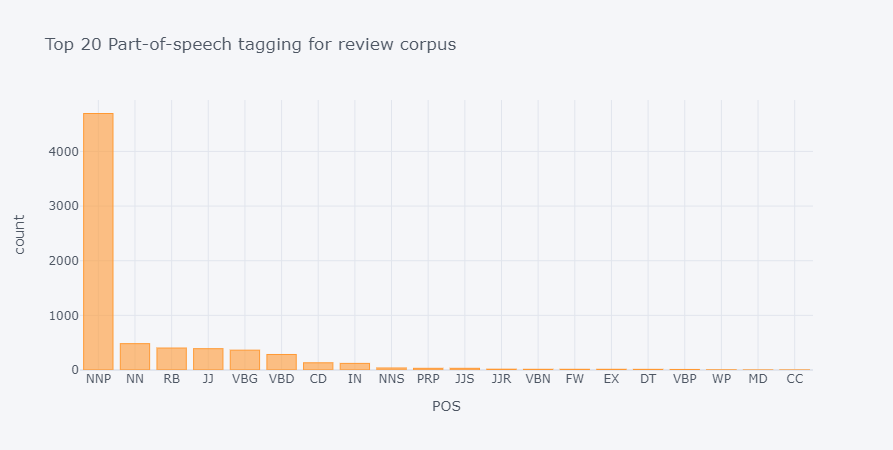

In [ ]:
nlp.plot_model(plot= 'pos')

## Modelagem: Classificação de Texto

### Ciclo 1: Modelagem por Tópicos

#### Feature Engineering in Text

Feito o Processamento de Texto, iremos explorar a utilização da modelagem de tópicos como forma de extrair features numéricas que representem o contexto do texto.

Um modelo de tópicos captura os tópicos de uma documento e os transforma em uma estrutura matemática, que permite examinar um conjunto de documentos e descobrir, com base nas estatísticas das palavras em cada um, quais podem ser os tópicos e qual é o equilíbrio de tópicos de cada documento.

Inicialmente temos a **hipótese** que este método não é o mais adequado pra solução do problema, uma vez que **o assunto entre duas frases não pode gerar inferência sobre a relação lógica entre estas**, que é nosso objetivo, além do fato de não termos conhecimento sobre a origem do texto, o que torne seu contexto (se houver) desconhecido, fazendo com que a definição adequada do número de tópicos (**hiperparâmetro do modelo**) não seja uma tarefa trivial). De todo modo aplicaremos, e posteriormente será feito um comparativo com outras abordagens de processamento para **validar** ou **desvalidar** tal hipótese.

In [ ]:
nlp.models()

,Name,Reference
ID,,
lda,Latent Dirichlet Allocation,gensim/models/ldamodel
lsi,Latent Semantic Indexing,gensim/models/lsimodel
hdp,Hierarchical Dirichlet Process,gensim/models/hdpmodel
rp,Random Projections,gensim/models/rpmodel
nmf,Non-Negative Matrix Factorization,sklearn.decomposition.NMF


In [ ]:
#Definição dos modelos
#O hiperparâmetro multi_core=True define o uso de todos os núcleos da CPU para paralelizar e acelerar o treinamento do modelo.
%time model_lda = nlp.create_model(model='lda', multi_core=True)
#model_lsi = nlp.create_model(model='lsi', multi_core=True)
#model_hdp = nlp.create_model(model='hdp', multi_core=True)
#model_rp = nlp.create_model(model='rp', multi_core=True)
#model_nmf = nlp.create_model(model='nmf', multi_core=True)

#Default: num_topics=4 

CPU times: user 23.9 s, sys: 2.09 s, total: 26 s
Wall time: 26.9 s


In [ ]:
%time lda_df = nlp.assign_model(model_lda)
lda_df 

CPU times: user 9.1 s, sys: 568 ms, total: 9.66 s
Wall time: 8.94 s


,index,id,premise,hypothesis,lang_abv,language,label,text,Topic_0,Topic_1,Topic_2,Topic_3,Dominant_Topic,Perc_Dominant_Topic
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0.0,comment consider formulating rule develop inte...,0.023548,0.927673,0.024039,0.024740,Topic 1,0.93
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2.0,issue wrestle practice group law firm say prac...,0.020164,0.019857,0.568392,0.391586,Topic 2,0.57
2,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0.0,know really defend grow say age know defend age,0.025113,0.025758,0.713685,0.235444,Topic 2,0.71
3,7,fdcd1bd867,From Cockpit Country to St Ann's Bay,From St Ann's Bay to Cockpit Country,en,English,2.0,cockpit country,0.723340,0.086589,0.087109,0.102962,Topic 0,0.72
4,8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1.0,look skin go trouble busy boss fire see slack,0.025792,0.025769,0.506969,0.441469,Topic 2,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,5184,7618dd5a26,"However, in the off field sentimental tourna...",The Jets have the most appealing story line,en,English,NaN,however field sentimental tournament falcon je...,0.270175,0.317250,0.394067,0.018509,Topic 2,0.39
9811,5188,3189b0ae29,see now in a situation like that the boys are ...,Everyone involved was the same age,en,English,NaN,see situation boy year old sexually involved t...,0.008769,0.008755,0.973750,0.008727,Topic 2,0.97
9812,5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock,en,English,NaN,soft texture buy variety shape hard type rock,0.377724,0.564672,0.029644,0.027961,Topic 1,0.56
9813,5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English,NaN,remember year remember come work use live wyli...,0.016287,0.015942,0.951847,0.015924,Topic 2,0.95


Há 6 colunas adicionais que foram adicionadas ao dataframe. `text` é o texto após todo o pré-processamento. `Topic_0 ... Topic_3` são as proporções do tópico e representam a distribuição de tópicos para cada documento. `Dominant_Topic` é o número do tópico com maior proporção e `Perc_Dominant_Topic` é a porcentagem de tópico dominante sobre 1 (mostrado apenas quando os modelos são estocásticos, ou seja, soma de todas as proporções igual a 1).

In [ ]:
nlp.evaluate_model(model_lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

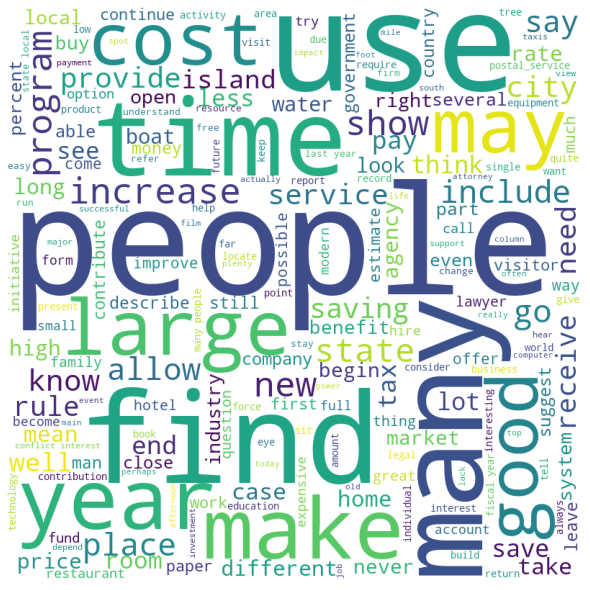

CPU times: user 11.9 s, sys: 1.09 s, total: 13 s
Wall time: 11.7 s


In [ ]:
%time nlp.plot_model(model_lda, plot='wordcloud')

# plot:
# 'bigram'
# 'trigram'
# 'topic_model'
# 'topic_distribution'
# 'sentiment'
# 'distribuition'
# 'tsne': T-distributed Stochastic Neighbor Embedding (t-SNE) é uma técnica de redução de dimensionalidade não linear adequada para incorporar dados de alta 
#dimensão para visualização em um espaço dimensional de duas ou três dimensões.

In [ ]:
#Mantendo somente as variáveis aptas para o treinamento dos modelos de classificação
df_topic_eng = lda_df.loc[:,['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'label']]
df_topic_eng

,Topic_0,Topic_1,Topic_2,Topic_3,label
0,0.023548,0.927673,0.024039,0.024740,0.0
1,0.020164,0.019857,0.568392,0.391586,2.0
2,0.025113,0.025758,0.713685,0.235444,0.0
3,0.723340,0.086589,0.087109,0.102962,2.0
4,0.025792,0.025769,0.506969,0.441469,1.0
...,...,...,...,...,...
9810,0.270175,0.317250,0.394067,0.018509,NaN
9811,0.008769,0.008755,0.973750,0.008727,NaN
9812,0.377724,0.564672,0.029644,0.027961,NaN
9813,0.016287,0.015942,0.951847,0.015924,NaN


#### Modelos de Classificação

Modelos disponíveis na biblioteca:

In [ ]:
#pyclass.models()

OBS:. Estimadores que usam métodos baseados em kernel, como Kernel Ridge Regressor, Automatic Relevance Determinant, Gaussian Process Classifier, Radial Basis Support Vector Machine e Multi Level Perceptron podem ter tempos de treinamento mais longos.


Metrics:
Accuracy, AUC, Recall, Precision, F1, Kappa.

Definição das configurações de inicialização da biblioteca:

In [ ]:
%time setup_class = pyclass.setup(data=df_topic_eng, target='label', session_id=5, train_size=0.7, preprocess=False)  

,Description,Value
0,session_id,5
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,"0.0: 0, 1.0: 1, 2.0: 2"
4,Original Data,"(9815, 5)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,0
8,Transformed Train Set,"(4778, 4)"
9,Transformed Test Set,"(2092, 4)"


CPU times: user 779 ms, sys: 34.2 ms, total: 813 ms
Wall time: 5.84 s


#### Avaliação dos Modelos

Comparação entre modelos:

In [ ]:
%time pyclass.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3556,0.4993,0.3389,0.2440,0.2749,0.0087,0.0114,0.7530
ridge,Ridge Classifier,0.3556,0.0000,0.3389,0.2440,0.2749,0.0087,0.0114,0.0110
lda,Linear Discriminant Analysis,0.3556,0.4991,0.3389,0.2439,0.2749,0.0087,0.0114,0.0120
dummy,Dummy Classifier,0.3556,0.5000,0.3333,0.1264,0.1866,0.0000,0.0000,0.0090
nb,Naive Bayes,0.3550,0.5098,0.3439,0.3462,0.3221,0.0169,0.0185,0.0140
svm,SVM - Linear Kernel,0.3435,0.0000,0.3394,0.2633,0.2712,0.0095,0.0112,0.0420
ada,Ada Boost Classifier,0.3391,0.5110,0.3357,0.3394,0.3350,0.0022,0.0022,0.1570
gbc,Gradient Boosting Classifier,0.3367,0.4989,0.3327,0.3377,0.3319,-0.0025,-0.0025,1.2170
qda,Quadratic Discriminant Analysis,0.3353,0.5074,0.3373,0.2677,0.2415,0.0061,0.0043,0.0160
knn,K Neighbors Classifier,0.3347,0.4977,0.3300,0.3271,0.3213,-0.0049,-0.0048,0.0840


CPU times: user 6.67 s, sys: 301 ms, total: 6.98 s
Wall time: 52.5 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Podemos observar que o modelo que obteve maior **Acurácia** foi o	**Dummy Classifier**, seguido do modelo **Naive Bayes**. Já na perspectiva da **Precisão** e demais métricas, o modelo que se saiu melhor foi o **Ada Boost Classifier**.




#### Ajuste de Hiperparâmetros

A partir destes resultados, abaixo será feito o **ajuste de hiperparâmetros** do modelo **ADA**, uma vez que foi o que se saiu melhor na maioria das métricas.

In [ ]:
%time best_model1 = pyclass.create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3368,0.5024,0.3336,0.3339,0.3313,-0.0011,-0.0012
1,0.3452,0.5107,0.3424,0.3439,0.3438,0.0138,0.0138
2,0.3452,0.5106,0.3412,0.3486,0.3393,0.0094,0.0096
3,0.3326,0.4901,0.3288,0.3292,0.3295,-0.0064,-0.0064
4,0.3640,0.5216,0.3596,0.3644,0.3585,0.0386,0.0393
5,0.3368,0.5279,0.3354,0.3394,0.3366,0.0008,0.0008
6,0.3431,0.5159,0.3407,0.3475,0.3418,0.0086,0.0086
7,0.3243,0.5247,0.3201,0.3234,0.3184,-0.0213,-0.0217
8,0.3333,0.5198,0.3275,0.3287,0.3248,-0.0092,-0.0094


CPU times: user 749 ms, sys: 10.9 ms, total: 760 ms
Wall time: 2.06 s


In [ ]:
%time tuned_best_model1 = pyclass.tune_model(best_model1, optimize='Accuracy') #Métrica a ser otimizada

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3556,0.5193,0.3333,0.1265,0.1866,0.0000,0.0000
1,0.3536,0.4950,0.3314,0.1260,0.1858,-0.0031,-0.0379
2,0.3556,0.5198,0.3333,0.1265,0.1866,0.0000,0.0000
3,0.3556,0.4963,0.3333,0.1265,0.1866,0.0000,0.0000
4,0.3556,0.5479,0.3333,0.1265,0.1866,0.0000,0.0000
5,0.3536,0.5434,0.3314,0.1260,0.1858,-0.0032,-0.0389
6,0.3556,0.5168,0.3333,0.1265,0.1866,0.0000,0.0000
7,0.3536,0.5124,0.3333,0.1250,0.1847,0.0000,0.0000
8,0.3564,0.5123,0.3333,0.1270,0.1873,0.0000,0.0000


CPU times: user 3.05 s, sys: 58.8 ms, total: 3.11 s
Wall time: 50.1 s


Podemos observar que o ajuste de hiperparâmetros não retornou diferença significativa pro primeiro treinamento do modelo **ADA**, e ainda reduziu o valor da **Precisão** de 34.18% para **13.41%**.

Faremos o mesmo processo para o modelo que performou em segundo lugar em valor de Acurácia, o modelo **Naive Bayes**, já que ele obteve uma Acurácia próxima do modelo em primeiro lugar, sem um valor tão baixo para a Precisão.

In [ ]:
%time best_model2 = pyclass.create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3536,0.5009,0.3437,0.3548,0.3277,0.0149,0.0159
1,0.3808,0.5409,0.3659,0.3746,0.3274,0.0522,0.0593
2,0.3285,0.5020,0.3160,0.2984,0.2877,-0.0256,-0.0282
3,0.3536,0.5093,0.3453,0.3431,0.3393,0.0200,0.0206
4,0.3828,0.5405,0.3697,0.3902,0.3370,0.0571,0.0631
5,0.3556,0.5031,0.3446,0.3443,0.3227,0.0182,0.0195
6,0.3536,0.5056,0.3437,0.3457,0.3294,0.0160,0.0169
7,0.3556,0.5160,0.3446,0.3298,0.3145,0.0188,0.0204
8,0.3543,0.5077,0.3442,0.3416,0.3303,0.0173,0.0183


CPU times: user 437 ms, sys: 24.7 ms, total: 462 ms
Wall time: 502 ms


In [ ]:
%time tuned_best_model2 = pyclass.tune_model(best_model2, optimize='Accuracy') #Métrica a ser otimizada

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3536,0.5009,0.3437,0.3548,0.3277,0.0149,0.0159
1,0.3808,0.5409,0.3659,0.3746,0.3274,0.0522,0.0593
2,0.3285,0.5020,0.3160,0.2984,0.2877,-0.0256,-0.0282
3,0.3536,0.5093,0.3453,0.3431,0.3393,0.0200,0.0206
4,0.3828,0.5405,0.3697,0.3902,0.3370,0.0571,0.0631
5,0.3556,0.5031,0.3446,0.3443,0.3227,0.0182,0.0195
6,0.3536,0.5056,0.3437,0.3457,0.3294,0.0160,0.0169
7,0.3556,0.5160,0.3446,0.3298,0.3145,0.0188,0.0204
8,0.3543,0.5077,0.3442,0.3416,0.3303,0.0173,0.0183


CPU times: user 1.19 s, sys: 28.3 ms, total: 1.21 s
Wall time: 1.38 s


In [ ]:
pyclass.evaluate_model(tuned_best_model1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Após o ajusto pro modelo de Naive Bayes, não obtivemos diferença significativa. 

Assim, adiane seguiremos com outra abordagem de **Feature Engineering** pré-modelagem.

### Ciclo 2: Transformação pelo Método Bag of Words

Neste ciclo de modelagem, será aplicado um método comum em Processamento de Texto, o **Método Bag of Words**, que consiste em transformar cada **token** em uma variável em si, onde o corpo do dataset assume valores boobleanos, indicando se aquela linha originalmente tinha ou não aquele token em seu conteúdo. 

Uma **hipótese que foi levantada** é que este **método não será individualmente melhor que a Extração de Features do texto**, pois esta transformação fará com que cada palavra tenha o mesmo peso como variável, e a **Alta Dimensionalidade** do dataset tornará o efeito sutil de algumas palavras ainda menos perceptível ao modelo.

#### Feature Engineering in Text

In [ ]:
df_union_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       9815 non-null   int64  
 1   id          9815 non-null   object 
 2   premise     9815 non-null   object 
 3   hypothesis  9815 non-null   object 
 4   lang_abv    9815 non-null   object 
 5   language    9815 non-null   object 
 6   label       6870 non-null   float64
 7   text        9815 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 613.6+ KB


Eliminando números do texto:

In [ ]:
df_union_eng['text'] = df_union_eng.text.apply(lambda x: re.sub(r'[0-9]+', ' ', x))
df_union_eng['text']

0       and these comments were considered in formulat...
1       these are issues that we wrestle with in pract...
2       you know they can't really defend themselves l...
3       from cockpit country to st  ann's bay from st ...
4       look, it's your skin, but you're going to be i...
                              ...                        
9810    however, in the off field  sentimental  tourna...
9811    see now in a situation like that the boys are ...
9812    the  rock  has a soft texture and can be bough...
9813    isn't it i can remember i've only been here ei...
9814    in hong kong you can have a plate, or even a w...
Name: text, Length: 9815, dtype: object

In [ ]:
df_union_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       9815 non-null   int64  
 1   id          9815 non-null   object 
 2   premise     9815 non-null   object 
 3   hypothesis  9815 non-null   object 
 4   lang_abv    9815 non-null   object 
 5   language    9815 non-null   object 
 6   label       6870 non-null   float64
 7   text        9815 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 613.6+ KB


Vetorização dos tokens:

Os parâmetros **max_d** e **min_df** determinam a porcentagem máxima e mínima de aparecimento das palavras tokenizadas no texto. As palavras tokenizadas selecionadas devem aparecer em **mais de 10%** e **menos de 95%** no texto, isso é para desmarcar palavras que aparecem muito raramente (que geram um volume de dimensões sem necessidade, uma vez que se o modelo aprender sobre estas palavras pouco frequentes, pode tem maior chance de sofrer efeito de **overfitting**) e com muita frequência (que não fornecem a informação necessária para o modelo **aprender a distinguir quais tokens levam a cada classe da variável target**).
Foi feita uma tentativa de vetorização sem definição destes parâmetros, mas os modelos de classificação não conseguiram rodar sobre esta alta quantidade de colunas.

O parâmetro **ngram_range** de (1,2) é definido para tokenizar 1 palavra e 2 palavras consecutivas, ou seja identificar **bigramas**. Isso é importante para detectar sequências de duas palavras que se repetem com muita frequência.

In [ ]:
cv1 = CountVectorizer(analyzer= 'word', token_pattern= r'(\s\w+\'\w+\s)', max_df=0.98, min_df=0.005, ngram_range=(1,1))   #"[\w+\'\w+]+[^\s]" )
vectorizer1 = cv1.fit(df_union_eng['text'])
#vectorizer.vocabulary_
#vectorizer.get_feature_names()
BoW1 = cv1.transform(df_union_eng['text'])
df_BoW1 = pd.DataFrame(BoW1.toarray(), columns=vectorizer1.get_feature_names())

In [ ]:
cv2 = CountVectorizer(analyzer= 'word', token_pattern= r'(?u)\b\w\w+\b', max_df=0.98, min_df=0.05, ngram_range=(1,2)) 
vectorizer2 = cv2.fit(df_union_eng['text'])
#vectorizer.vocabulary_
#vectorizer.get_feature_names()
BoW2 = cv2.transform(df_union_eng['text'])
df_BoW2 = pd.DataFrame(BoW2.toarray(), columns=vectorizer2.get_feature_names()) 
df_BoW2

,about,all,an,and,are,as,at,be,been,but,...,up,was,we,well,were,when,will,with,yeah,you
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2,0,0,1,0,0
1,0,0,0,0,2,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9811,0,1,0,3,1,0,3,0,0,0,...,0,2,0,0,1,1,0,1,0,4
9812,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9813,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_BoW = pd.concat([df_BoW1, df_BoW2], axis=1, ignore_index=False)
df_BoW['label'] = df_union_eng['label'].values  
#A delacração do valor precisa ser com base no atributo .values, pois do contrário o pandas usará a informação do índice como referência para atribuição de 
#valores linha a linha, e os índices possuem quebras na sequência devido terem passado por diversas etapas de processamento.

df_BoW

,aren't,can't,didn't,doesn't,don't,he's,i'll,i'm,i've,isn't,...,was,we,well,were,when,will,with,yeah,you,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,1,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,2.0
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9811,0,0,0,0,0,0,0,0,0,0,...,2,0,0,1,1,0,1,0,4,NaN
9812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9813,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,NaN


In [ ]:
str_match = [s for s in list(pd.Series(df_BoW.columns).unique()) if "ll"==s ]
print(str_match)

[]


#### Modelos de Classificação

Modelos disponíveis na biblioteca:

In [ ]:
#pyclass.models()

OBS:. Estimadores que usam métodos baseados em kernel, como Kernel Ridge Regressor, Automatic Relevance Determinant, Gaussian Process Classifier, Radial Basis Support Vector Machine e Multi Level Perceptron podem ter tempos de treinamento mais longos.


Metrics:
Accuracy, AUC, Recall, Precision, F1, Kappa.

Definição das configurações de inicialização da biblioteca:

In [ ]:
%time setup_class = pyclass.setup(data=df_BoW, target='label', session_id=5, train_size=0.7, preprocess=False)   

,Description,Value
0,session_id,5
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,"0.0: 0, 1.0: 1, 2.0: 2"
4,Original Data,"(9815, 78)"
5,Missing Values,True
6,Numeric Features,0
7,Categorical Features,77
8,Transformed Train Set,"(4778, 77)"
9,Transformed Test Set,"(2092, 77)"


CPU times: user 2.7 s, sys: 76.8 ms, total: 2.78 s
Wall time: 6.67 s


#### Avaliação dos Modelos

Comparação entre modelos:

In [ ]:
%time pyclass.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.4186,0.5762,0.4119,0.4233,0.4094,0.1198,0.1236,1.2810
ada,Ada Boost Classifier,0.4165,0.5769,0.4120,0.4199,0.4108,0.1192,0.1215,2.4080
ridge,Ridge Classifier,0.3797,0.0000,0.3714,0.3756,0.3650,0.0586,0.0608,0.1700
lda,Linear Discriminant Analysis,0.3784,0.5329,0.3705,0.3749,0.3651,0.0572,0.0591,0.1840
lr,Logistic Regression,0.3765,0.5320,0.3685,0.3715,0.3626,0.0542,0.0561,0.3570
svm,SVM - Linear Kernel,0.3573,0.0000,0.3501,0.3461,0.3293,0.0261,0.0269,0.2570
dummy,Dummy Classifier,0.3556,0.5000,0.3333,0.1264,0.1866,0.0000,0.0000,0.1610
nb,Naive Bayes,0.3384,0.5043,0.3393,0.3486,0.3283,0.0093,0.0098,0.1670
dt,Decision Tree Classifier,0.3290,0.4973,0.3282,0.3288,0.3286,-0.0081,-0.0082,0.1830
rf,Random Forest Classifier,0.3215,0.4884,0.3196,0.3212,0.3206,-0.0216,-0.0216,0.6730


CPU times: user 35.1 s, sys: 4.28 s, total: 39.4 s
Wall time: 1min 27s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Podemos observar que o modelo que obteve maior **Acurácia** foi o  **Gradient Boosting Classifier** empatado com o **Ada Boost Classifier**, sendo que o segundo teve uma **Precisão** um pouco maior.



#### Ajuste de Hiperparâmetros

A partir destes resultados, abaixo será feito o **ajuste de hiperparâmetros**.

##### GBC Model

In [ ]:
%time best_model1 = pyclass.create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4226,0.5709,0.4165,0.4295,0.4156,0.1264,0.1300
1,0.3849,0.5488,0.3792,0.3833,0.3792,0.0720,0.0729
2,0.4163,0.6014,0.4084,0.4162,0.4047,0.1159,0.1197
3,0.4038,0.5636,0.3944,0.4056,0.3858,0.0939,0.0994
4,0.4414,0.5801,0.4364,0.4443,0.4369,0.1558,0.1582
5,0.4121,0.5758,0.4043,0.4093,0.3990,0.1094,0.1131
6,0.4289,0.5954,0.4225,0.4378,0.4203,0.1341,0.1389
7,0.4372,0.5787,0.4317,0.4434,0.4305,0.1491,0.1530
8,0.4109,0.5702,0.4052,0.4241,0.4049,0.1085,0.1121


CPU times: user 5.19 s, sys: 243 ms, total: 5.43 s
Wall time: 16.6 s


In [ ]:
%time tuned_best_model1 = pyclass.tune_model(best_model1, optimize='Accuracy') #Métrica a ser otimizada

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4226,0.5900,0.4106,0.4292,0.3943,0.1197,0.1317
1,0.4393,0.5791,0.4288,0.4400,0.4184,0.1477,0.1568
2,0.4121,0.5894,0.4013,0.4263,0.3894,0.1039,0.1137
3,0.3891,0.5790,0.3772,0.4040,0.3583,0.0667,0.0749
4,0.4498,0.5987,0.4378,0.4529,0.4234,0.1620,0.1748
5,0.4038,0.5647,0.3930,0.4038,0.3803,0.0928,0.0999
6,0.4289,0.6026,0.4170,0.4369,0.4016,0.1292,0.1413
7,0.4247,0.6060,0.4131,0.4211,0.3943,0.1242,0.1355
8,0.4109,0.5814,0.3979,0.4324,0.3785,0.0991,0.1135


CPU times: user 22.4 s, sys: 2.69 s, total: 25.1 s
Wall time: 2min 14s


Os resultados mostram que saímos de uma média da **Acurácia** de **41.86%** para **42.03%**, além de ter aumentado a **Precisão** de **42.33%** para **42.86%**.

Faremos o mesmo processo para o modelo que performou em segundo lugar, o modelo de **Ada Boost Classifier**.

In [ ]:
pyclass.evaluate_model(tuned_best_model1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
#df_BoW.iloc[:int(df_BoW.index.max()*0.7),0:-1]

##### ADA Model

In [ ]:
%time best_model2 = pyclass.create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4331,0.5836,0.4282,0.4442,0.4272,0.1434,0.1474
1,0.3682,0.5404,0.3649,0.3673,0.3657,0.0491,0.0494
2,0.4163,0.5977,0.4093,0.4177,0.4073,0.1179,0.1208
3,0.3975,0.5711,0.3910,0.3973,0.3866,0.0879,0.0907
4,0.4226,0.5621,0.4218,0.4224,0.4205,0.1315,0.1321
5,0.4414,0.5863,0.4375,0.4400,0.4360,0.1587,0.1604
6,0.4289,0.5716,0.4228,0.4369,0.4225,0.1351,0.1389
7,0.4351,0.5943,0.4322,0.4402,0.4325,0.1493,0.1510
8,0.4109,0.5753,0.4064,0.4175,0.4053,0.1098,0.1124


CPU times: user 8.22 s, sys: 232 ms, total: 8.45 s
Wall time: 29.9 s


In [ ]:
%time tuned_best_model2 = pyclass.tune_model(best_model2, optimize='Accuracy') #Métrica a ser otimizada

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4268,0.5745,0.4186,0.4289,0.4129,0.1307,0.1362
1,0.4100,0.5613,0.4020,0.4094,0.3980,0.1067,0.1102
2,0.4079,0.5986,0.3980,0.4063,0.3894,0.1009,0.1064
3,0.4038,0.5773,0.3938,0.4041,0.3815,0.0929,0.0994
4,0.4477,0.5813,0.4421,0.4537,0.4412,0.1642,0.1683
5,0.4205,0.5793,0.4130,0.4178,0.4082,0.1227,0.1264
6,0.4310,0.5896,0.4234,0.4391,0.4207,0.1371,0.1427
7,0.4456,0.6063,0.4382,0.4564,0.4337,0.1596,0.1672
8,0.4046,0.5701,0.3976,0.4147,0.3944,0.0966,0.1011


CPU times: user 46.7 s, sys: 2.77 s, total: 49.5 s
Wall time: 15min 20s


Podemos observar que o ajuste de hiperparâmetros retornou uma uma média de **Acurácia** de **41.65%** para **42.19%**, além de ter aumentado a **Precisão** de **41.99%** para **42.61%**, o que supera o modelo **Gradient Boosting Classifier** treinado anteriormene nas duas métricas.

Assim como a literatura científica já explora, um conjunto de dados no formato de **matriz esparsa** (onde **maioria dos atributos** do objeto **contém valores 0**, sendo que o interesse está nos valores não-zeros), costuma ser de difícil compreensão para os modelos, por muitas vezes trazerem atributos irrelevantes e ruídos para o aprendizado.

### Ciclo 3: Feature Extraction

Neste terceiro ciclo de modelagem, será feita a extração de Features que **exprimam características** identificadas por terem maior **potencial de resolução** do problema, e posteriormente realizar a modelagem.

In [ ]:
from nltk.data import load
import nltk

In [ ]:
nltk.download('tagsets')

[nltk_data] Downloading package tagsets to /usr/share/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [ ]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
tagdict['NN'][0]
tagdict.keys()

dict_keys(['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS'])

In [ ]:
for tag in tagdict.keys():
    print(str(nltk.help.upenn_tagset(tag))+'\n------------------------------\n')

#### Tempo Verbal

##### Feature Extraction

Após explorar o dicionário de TAGs disponível pelo etiquetador do NLTK, decediu-se fazer nesta etapa a extração do **tempo verbal** presente na sentença completa, ou seja Premissa + Hipótese.

Será usado o dataset inical `df_train_eng`, que passou apenas pelo Processamento de Texto básico: 
- Normalização do texto (transformação de palavras maiúsculas em minúsculas);
- Eliminação de caracteres especiais (exceto aspas simples); 

In [49]:
# Tokenização do texto por linha.
tokenizer = RegexpTokenizer(r"\s+", gaps=True) 

df_train_eng['tokens'] = df_train_eng['text'].apply(lambda x: re.sub(",", '', x)).apply(lambda x: tokenizer.tokenize(x) )
df_union_eng['tokens'] = df_union_eng['text'].apply(lambda x: re.sub(",", '', x)).apply(lambda x: tokenizer.tokenize(x) )

df_train_eng['tokens'] 

0       [and, these, comments, were, considered, in, f...
1       [these, are, issues, that, we, wrestle, with, ...
2       [you, know, they, can't, really, defend, thems...
3       [from, cockpit, country, to, st, ann's, bay, f...
4       [look, it's, your, skin, but, you're, going, t...
                              ...                        
6865    [the, results, of, even, the, most, well, desi...
6866    [but, there, are, two, kinds, of, the, pleasur...
6867    [the, important, thing, is, to, realize, that,...
6868    [at, the, west, end, is, a, detailed, model, o...
6869    [for, himself, he, chose, atat, rk, or, father...
Name: tokens, Length: 6870, dtype: object

In [50]:
# Tagueamento das classes gramaticais do texto por linha.
df_train_eng['tokens_tag'] = df_train_eng['tokens'].apply(lambda x: nltk_pos_tag(x) )
df_union_eng['tokens_tag'] = df_union_eng['tokens'].apply(lambda x: nltk_pos_tag(x) )

df_train_eng['tokens_tag']

0       [(and, CC), (these, DT), (comments, NNS), (wer...
1       [(these, DT), (are, VBP), (issues, NNS), (that...
2       [(you, PRP), (know, VBP), (they, PRP), (can't,...
3       [(from, IN), (cockpit, JJ), (country, NN), (to...
4       [(look, NN), (it's, VB), (your, PRP$), (skin, ...
                              ...                        
6865    [(the, DT), (results, NNS), (of, IN), (even, R...
6866    [(but, CC), (there, EX), (are, VBP), (two, CD)...
6867    [(the, DT), (important, JJ), (thing, NN), (is,...
6868    [(at, IN), (the, DT), (west, JJ), (end, NN), (...
6869    [(for, IN), (himself, PRP), (he, PRP), (chose,...
Name: tokens_tag, Length: 6870, dtype: object

In [51]:
# Coluna contendo a quantidade de verbos da sentença unificada.
a=0

#func_qtdVB = lambda x: reduce(sum(), [a+1 for i, tok in enumerate(x) if tok[1][:2]=='VB'])
func_qtdVB = lambda x: np.sum([a+1 for i, tok in enumerate(x) if tok[1][:2]=='VB'])

df_train_eng['qtd_verbs'] = df_train_eng['tokens_tag'].apply(func_qtdVB)
df_union_eng['qtd_verbs'] = df_union_eng['tokens_tag'].apply(func_qtdVB)

df_train_eng['qtd_verbs'] 

0       6.0
1       6.0
2       7.0
3       2.0
4       8.0
       ... 
6865    8.0
6866    6.0
6867    6.0
6868    3.0
6869    2.0
Name: qtd_verbs, Length: 6870, dtype: float64

In [52]:
# Número máximo de verbos por sentença
qtd_max_verbs = np.max(df_train_eng['qtd_verbs'])
qtd_max_verbs 

64.0

In [53]:
#Filtrando a linha com maior quantidade de verbos
#df_train_eng['text'][df_train_eng['qtd_verbs']==64.0].values

df_train_eng.loc[df_train_eng['qtd_verbs']==qtd_max_verbs]

,index,id,premise,hypothesis,lang_abv,language,label,text,score_similaridade_lex,tokens,tokens_tag,qtd_verbs,verbs_tag,tokPrem,tokHip,qtd_tokens,qtd_tokens_prem,qtd_tokens_hip
3924,6931,2b8b1bd7e9,and i look back on that and i bought shoes i w...,My friends should look towards me as a model o...,en,English,1,and i look back on that and i bought shoes i w...,0.058252,"[and, i, look, back, on, that, and, i, bought,...","[(and, CC), (i, VB), (look, VBP), (back, RB), ...",64.0,"[(i, VB), (look, VBP), (i, VB), (bought, VBD),...","[and, i, look, back, on, that, and, i, bought,...","[My, friends, should, look, towards, me, as, a...",206,194,12


In [54]:
#Filtrando a linha com maior quantidade de verbos
df_train_eng.loc[df_train_eng['qtd_verbs']==qtd_max_verbs, 'text'].values

array(["and i look back on that and i bought shoes i went shopping i did not need that money i did not need it i didn't need it i shouldn't have even qualified to get it i didn't need it and it would have been a little rough i might have eaten some bologna instead of roast beef out of the deli but i did not need it and as i look back now now we're paying that back i told my son if you have to live in the ghetto to go to college do it but don't take out ten thousand dollars in loans don't do it and i don't i hope don't think he'll have to do that but i just so like we might if we didn't have those loans we could have saved in the last five years the money for that and i believe we would have because god's really put it in our heart not to get in debt you know but we have friends at church that do this on a constant basis that are totally debt free and they pay cash for everything they buy my friends should look towards me as a model of saving money "],
      dtype=object)

In [55]:
# Definição das funções para extrair os tokens que contêm a tag de verbo (prefixo 'VB')

global list_verb_tag
list_verb_tag = []

def mask_contain_verb(x):
    m_temp = []
    for token in x:
        try:
            str(token).index('VB')
            m_temp.append(True)
        except ValueError:
            m_temp.append(False)
            # except:
            #   m_temp.append(token)
    return m_temp

def extract_verb(x):
    #mask_a = numpy.ma.masked_array(list(map(tup_contain_verb, df_train_eng['tokens_tag'][0])), fill_value=False) 
    mask_x = mask_contain_verb(x['tokens_tag'])
    verbs_tag = []  

    for verb in list(pd.Series(x['tokens_tag'])[mask_x].values):
        tup_list = (int(pd.Series(x).name), verb[0], verb[1][2:], x['label'])
        tup_df = (verb[0], verb[1])
        verbs_tag.append(tup_df)  
        list_verb_tag.append(tup_list) 
    return verbs_tag

In [56]:
df_train_eng['verbs_tag'] = df_train_eng.apply(lambda serie: extract_verb(serie), axis=1, raw=False )#, result_type='expand')
df_train_eng 

,index,id,premise,hypothesis,lang_abv,language,label,text,score_similaridade_lex,tokens,tokens_tag,qtd_verbs,verbs_tag,tokPrem,tokHip,qtd_tokens,qtd_tokens_prem,qtd_tokens_hip
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,and these comments were considered in formulat...,0.437500,"[and, these, comments, were, considered, in, f...","[(and, CC), (these, DT), (comments, NNS), (wer...",6.0,"[(were, VBD), (considered, VBN), (formulating,...","[and, these, comments, were, considered, in, f...","[The, rules, developed, in, the, interim, were...",24,10,14
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,these are issues that we wrestle with in pract...,0.136364,"[these, are, issues, that, we, wrestle, with, ...","[(these, DT), (are, VBP), (issues, NNS), (that...",6.0,"[(are, VBP), (wrestle, VBP), (said, VBD), (are...","[These, are, issues, that, we, wrestle, with, ...","[Practice, groups, are, not, permitted, to, wo...",25,15,10
2,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,you know they can't really defend themselves l...,0.210526,"[you, know, they, can't, really, defend, thems...","[(you, PRP), (know, VBP), (they, PRP), (can't,...",7.0,"[(know, VBP), (can't, VBP), (defend, VBP), (sa...","[you, know, they, can't, really, defend, thems...","[They, can't, defend, themselves, because, of,...",25,17,8
3,7,fdcd1bd867,From Cockpit Country to St Ann's Bay,From St Ann's Bay to Cockpit Country,en,English,2,from cockpit country to st ann's bay from st ...,1.000000,"[from, cockpit, country, to, st, ann's, bay, f...","[(from, IN), (cockpit, JJ), (country, NN), (to...",2.0,"[(st, VB), (cockpit, VB)]","[From, Cockpit, Country, to, St, Ann's, Bay]","[From, St, Ann's, Bay, to, Cockpit, Country]",14,7,7
4,8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1,"look, it's your skin, but you're going to be i...",0.083333,"[look, it's, your, skin, but, you're, going, t...","[(look, NN), (it's, VB), (your, PRP$), (skin, ...",8.0,"[(it's, VB), (going, VBG), (be, VB), (don't, V...","[Look,, it's, your, skin,, but, you're, going,...","[The, boss, will, fire, you, if, he, sees, you...",27,16,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6865,12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2,the results of even the most well designed epi...,0.114286,"[the, results, of, even, the, most, well, desi...","[(the, DT), (results, NNS), (of, IN), (even, R...",8.0,"[(designed, VBN), (are, VBP), (characterized, ...","[The, results, of, even, the, most, well, desi...","[All, studies, have, the, same, amount, of, un...",46,36,10
6866,12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0,but there are two kinds of the pleasure of do...,0.857143,"[but, there, are, two, kinds, of, the, pleasur...","[(but, CC), (there, EX), (are, VBP), (two, CD)...",6.0,"[(are, VBP), (doing, VBG), (doing, VBG), (are,...","[But, there, are, two, kinds, of, the, pleasur...","[But, there, are, two, kinds, of, the, pleasur...",41,25,16
6867,12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever",en,English,2,the important thing is to realize that it's wa...,0.000000,"[the, important, thing, is, to, realize, that,...","[(the, DT), (important, JJ), (thing, NN), (is,...",6.0,"[(is, VBZ), (realize, VB), (move, VB), (cannot...","[The, important, thing, is, to, realize, that,...","[It, cannot, be, moved,, now, or, ever]",21,14,7
6868,12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end,en,English,2,at the 

Didionário das TAGs: https://levitrares.com/host-https-www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [57]:
# Expandindo a tupla da TAG, separando a coluna de Verbo e a coluna da etiqueta.
df_verbs = pd.DataFrame(list_verb_tag, columns=['index', 'token', 'tag', 'label'])
df_verbs['tag'] = df_verbs.tag.apply(lambda x: 'VB' if x=='' else x) 
df_verbs 

,index,token,tag,label
0,0,were,D,0
1,0,considered,N,0
2,0,formulating,G,0
3,0,developed,N,0
4,0,were,D,0
...,...,...,...,...
38125,6868,is,Z,2
38126,6868,complex,P,2
38127,6868,is,Z,2
38128,6869,chose,D,0


In [58]:
df_verbs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38130 entries, 0 to 38129
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   38130 non-null  int64 
 1   token   38130 non-null  object
 2   tag     38130 non-null  object
 3   label   38130 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [59]:
df_verbs['label'] = df_verbs['label'].astype('object')
df_verbs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38130 entries, 0 to 38129
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   38130 non-null  int64 
 1   token   38130 non-null  object
 2   tag     38130 non-null  object
 3   label   38130 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


##### Análise Exploratória

In [60]:
def func_de_para(x):
    if x==0:
        return 'Entailment'
    elif x==1:
        return 'Neutral'
    elif x==2:
        return 'Contradiction'

In [61]:
df_train_eng['category_label'] = df_train_eng.label.apply(func_de_para)

Quantidade de Verbos x Label

In [62]:
df_train_eng.loc[:, ['qtd_verbs', 'category_label']].groupby(by='category_label').mean()

,qtd_verbs
category_label,
Contradiction,5.465525
Entailment,5.481253
Neutral,5.716528


Análise das Labels e Tags

In [63]:
df_verbs2 = pd.get_dummies(data=df_verbs, prefix='label', columns=['label'])
df_verbs2.rename(columns={'label_0':'Entailment', 'label_1':'Neutral', 'label_2':'Contradiction'}, inplace=True)             
df_verbs2 

,index,token,tag,Entailment,Neutral,Contradiction
0,0,were,D,1,0,0
1,0,considered,N,1,0,0
2,0,formulating,G,1,0,0
3,0,developed,N,1,0,0
4,0,were,D,1,0,0
...,...,...,...,...,...,...
38125,6868,is,Z,0,0,1
38126,6868,complex,P,0,0,1
38127,6868,is,Z,0,0,1
38128,6869,chose,D,1,0,0


In [64]:
# Agrupando os dados pela contagem das labels por TAGs, para descobrir qual o tempo verbal mais frequente em cada label, se houver.
# A operação de soma é mais performática que a operação de contagem.
df_label_by_tag = df_verbs2.loc[:, ['tag','Entailment','Neutral','Contradiction']].groupby(by=['tag']).sum().sort_values(by=['Entailment','Neutral','Contradiction'], ascending=False )
df_label_by_tag

,Entailment,Neutral,Contradiction
tag,,,
VB,2966.0,2866.0,2844.0
D,2724.0,2540.0,2526.0
P,2422.0,2345.0,2354.0
N,1945.0,1695.0,1734.0
Z,1888.0,1668.0,1802.0
G,1358.0,1268.0,1185.0


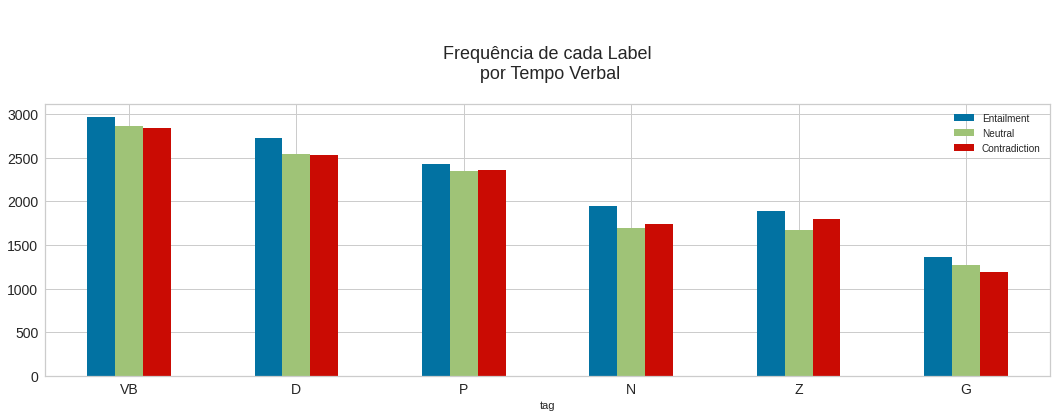

In [65]:
fig, ax = plt.subplots(figsize=(18,5))

df_label_by_tag = df_label_by_tag.reset_index()
df_label_by_tag.plot(x='tag', y=['Entailment','Neutral','Contradiction'], kind='bar', ax=ax)


plt.title('\n\nFrequência de cada Label\n por Tempo Verbal\n', size=18)
plt.xticks(size=14, rotation=0)
plt.yticks(size=14)
plt.show() 

In [66]:
df_verbs3 = pd.get_dummies(data=df_verbs, prefix='tag', columns=['tag'])    
df_verbs3['label'] = df_verbs3.label.apply(func_de_para)         
df_verbs3 

,index,token,label,tag_D,tag_G,tag_N,tag_P,tag_VB,tag_Z
0,0,were,Entailment,1,0,0,0,0,0
1,0,considered,Entailment,0,0,1,0,0,0
2,0,formulating,Entailment,0,1,0,0,0,0
3,0,developed,Entailment,0,0,1,0,0,0
4,0,were,Entailment,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
38125,6868,is,Contradiction,0,0,0,0,0,1
38126,6868,complex,Contradiction,0,0,0,1,0,0
38127,6868,is,Contradiction,0,0,0,0,0,1
38128,6869,chose,Entailment,1,0,0,0,0,0


In [67]:
# Agrupando os dados pela contagem das tags por label
# A operação de soma é mais performática que a operação de contagem.
df_tag_by_label = df_verbs3.iloc[:, 2:].groupby(by=['label']).sum().sort_values(by=['tag_VB'], ascending=False )
df_tag_by_label.reset_index(inplace=True)
df_tag_by_label

,label,tag_D,tag_G,tag_N,tag_P,tag_VB,tag_Z
0,Entailment,2724.0,1358.0,1945.0,2422.0,2966.0,1888.0
1,Neutral,2540.0,1268.0,1695.0,2345.0,2866.0,1668.0
2,Contradiction,2526.0,1185.0,1734.0,2354.0,2844.0,1802.0


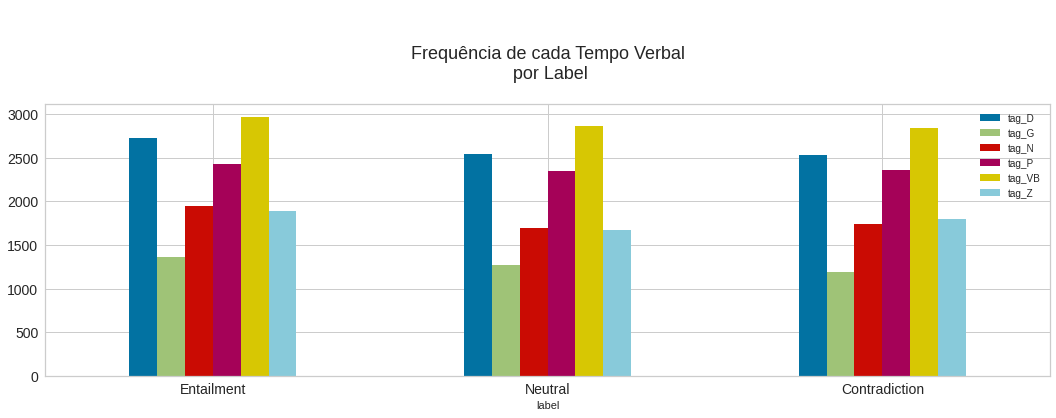

In [68]:
fig, ax = plt.subplots(figsize=(18,5))

df_tag_by_label.plot(x='label', y=list(df_tag_by_label.columns)[1:], kind='bar', ax=ax)


plt.title('\n\nFrequência de cada Tempo Verbal\n por Label\n', size=18)
plt.xticks(size=14, rotation=0)
plt.yticks(size=14)
plt.show() 

A partir dos dados apresentados, podemos constatar que há uma diferença sutil de frequência, mas **não existe grande predominância de um tempo verbal específico em uma determinada label**, pois a frequência de cada tempo verbal se distribui de forma proporcional para cada uma das labels.

#### Tokens

##### Análise Exploratória

* **Quantidade de Tokens x Label**

In [69]:
df_train_eng['tokPrem'] = df_train_eng['premise'].apply(lambda x: tokenizer.tokenize(x) )
df_train_eng['tokHip'] = df_train_eng['hypothesis'].apply(lambda x: tokenizer.tokenize(x) )

df_union_eng['tokPrem'] = df_union_eng['premise'].apply(lambda x: tokenizer.tokenize(x) )
df_union_eng['tokHip'] = df_union_eng['hypothesis'].apply(lambda x: tokenizer.tokenize(x) )

In [70]:
df_train_eng['qtd_tokens'] = df_train_eng['tokens'].apply(lambda x: len(x))
df_train_eng['qtd_tokens_prem'] = df_train_eng['tokPrem'].apply(lambda x: len(x))
df_train_eng['qtd_tokens_hip'] = df_train_eng['tokHip'].apply(lambda x: len(x))

df_union_eng['qtd_tokens'] = df_union_eng['tokens'].apply(lambda x: len(x))
df_union_eng['qtd_tokens_prem'] = df_union_eng['tokPrem'].apply(lambda x: len(x))
df_union_eng['qtd_tokens_hip'] = df_union_eng['tokHip'].apply(lambda x: len(x))

In [71]:
df_train_eng.loc[:, ['category_label', 'qtd_tokens']].groupby(by='category_label').describe().loc[['Contradiction', 'Neutral', 'Entailment'], :]

qtd_tokens                                                    
                    count       mean        std  min   25%   50%   75%    max
category_label                                                               
Contradiction      2277.0  28.886254  16.453021  2.0  18.0  26.0  37.0  204.0
Neutral            2166.0  30.333333  17.296455  3.0  19.0  27.0  38.0  216.0
Entailment         2427.0  29.439637  16.153477  2.0  18.0  27.0  39.0  169.0

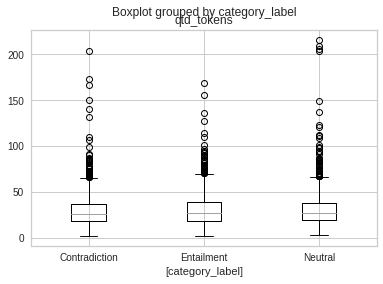

In [72]:
df_train_eng.loc[:, ['category_label', 'qtd_tokens']].boxplot(by='category_label')

* **Proporção Qtd. Tokens Premissa / Qtd. Tokens Hipótese**

In [73]:
df_train_eng['qtdPrem/qtdHip'] = df_train_eng['qtd_tokens_prem']/df_train_eng['qtd_tokens_hip'] 

df_union_eng['qtdPrem/qtdHip'] = df_union_eng['qtd_tokens_prem']/df_union_eng['qtd_tokens_hip'] 

In [74]:
df_train_eng.loc[:, ['category_label', 'qtdPrem/qtdHip']].groupby(by='category_label').describe().loc[['Contradiction', 'Neutral', 'Entailment'], :]

qtdPrem/qtdHip                                          \
                        count      mean       std       min       25%   
category_label                                                          
Contradiction          2277.0  2.180915  1.653451  0.090909  1.166667   
Neutral                2166.0  1.961759  1.577514  0.125000  1.000000   
Entailment             2427.0  2.026859  1.409125  0.111111  1.142857   

                                     
                     50%  75%   max  
category_label                       
Contradiction   1.750000  2.7  24.5  
Neutral         1.571429  2.5  23.2  
Entailment      1.666667  2.5  17.0

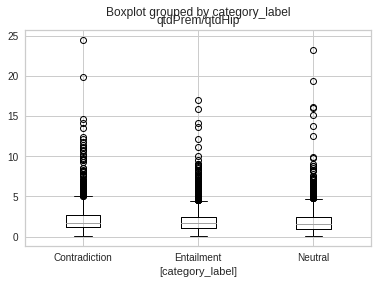

In [75]:
df_train_eng.loc[:, ['category_label', 'qtdPrem/qtdHip']].boxplot(by='category_label')

* **Quantidade de vírgulas**

In [76]:
df_train_eng['qtd_virgulas'] = df_train_eng['text'].apply(lambda x: x.count(','))

df_union_eng['qtd_virgulas'] = df_union_eng['text'].apply(lambda x: x.count(','))

In [77]:
df_train_eng.loc[:, ['category_label', 'qtd_virgulas']].groupby(by='category_label').describe().loc[['Contradiction', 'Neutral', 'Entailment'], :]

qtd_virgulas                                              
                      count      mean       std  min  25%  50%  75%   max
category_label                                                           
Contradiction        2277.0  0.981116  1.337933  0.0  0.0  1.0  2.0  12.0
Neutral              2166.0  1.027701  1.390223  0.0  0.0  1.0  2.0  12.0
Entailment           2427.0  1.063041  1.466492  0.0  0.0  1.0  2.0  12.0

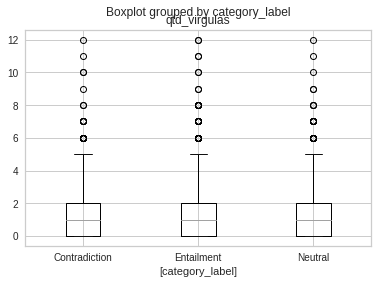

In [78]:
df_train_eng.loc[:, ['category_label', 'qtd_virgulas']].boxplot(by='category_label')

Quantidade de Tokens únicos

In [79]:
len(df_verbs.token.unique())

3977

In [80]:
df_label_by_token = df_verbs2.loc[:, ['token', 'Entailment','Neutral','Contradiction']].groupby(by=['token']).sum().sort_values(by=['Entailment','Neutral','Contradiction'], ascending=False )
df_label_by_token

,Entailment,Neutral,Contradiction
token,,,
is,891.0,769.0,837.0
was,610.0,583.0,578.0
are,493.0,484.0,433.0
be,432.0,405.0,367.0
have,381.0,391.0,360.0
...,...,...,...
whipped,0.0,0.0,1.0
wont,0.0,0.0,1.0
yesdave,0.0,0.0,1.0


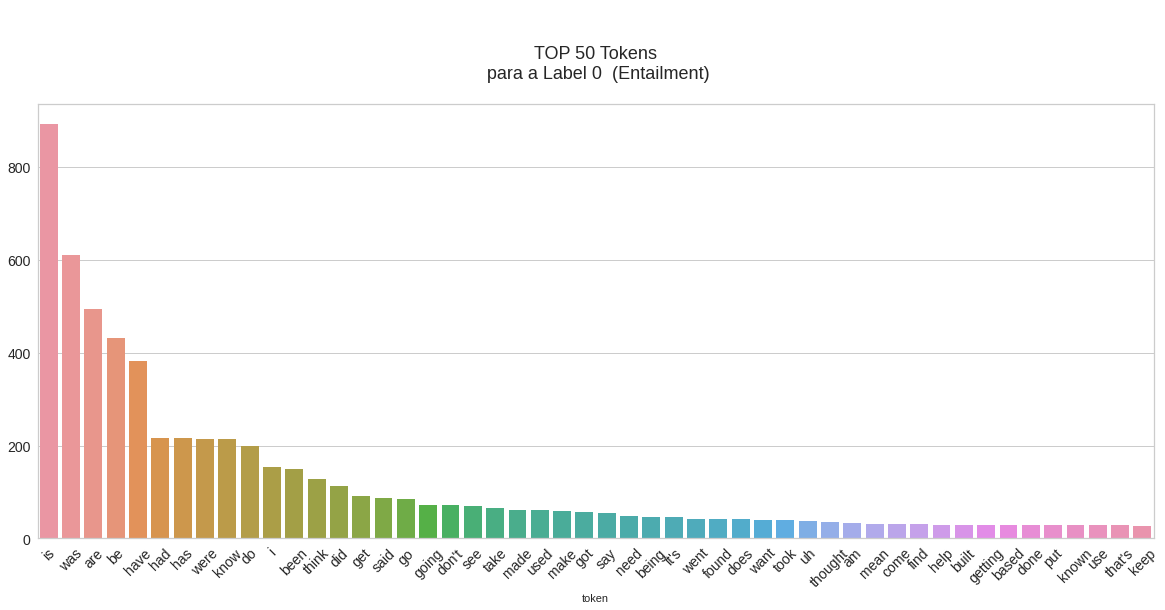

In [81]:
#fig, ax = plt.subplots()

plt.figure(figsize=(20,8))
sns.barplot(x=df_label_by_token['Entailment'].head(50).index, y=df_label_by_token['Entailment'].head(50).values) #, axis=ax) 
plt.title('\n\nTOP 50 Tokens\n para a Label 0  (Entailment)\n', size=18)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)
plt.show()

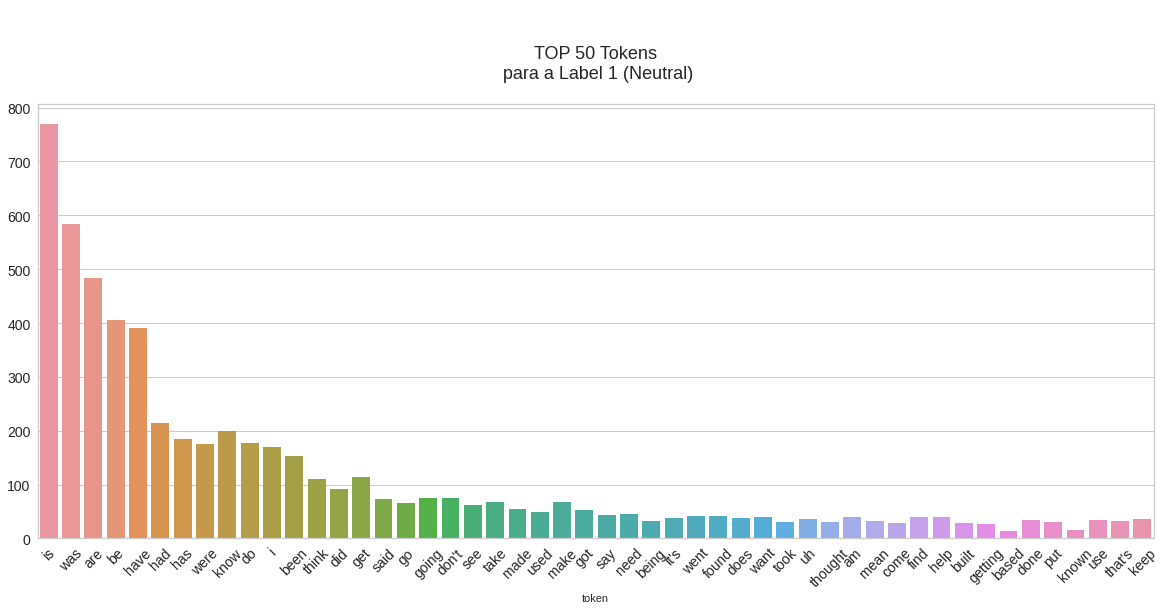

In [82]:
plt.figure(figsize=(20,8))
sns.barplot(x=df_label_by_token['Neutral'].head(50).index, y=df_label_by_token['Neutral'].head(50).values) 
plt.title('\n\nTOP 50 Tokens\n para a Label 1 (Neutral)\n', size=18)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)
plt.show()

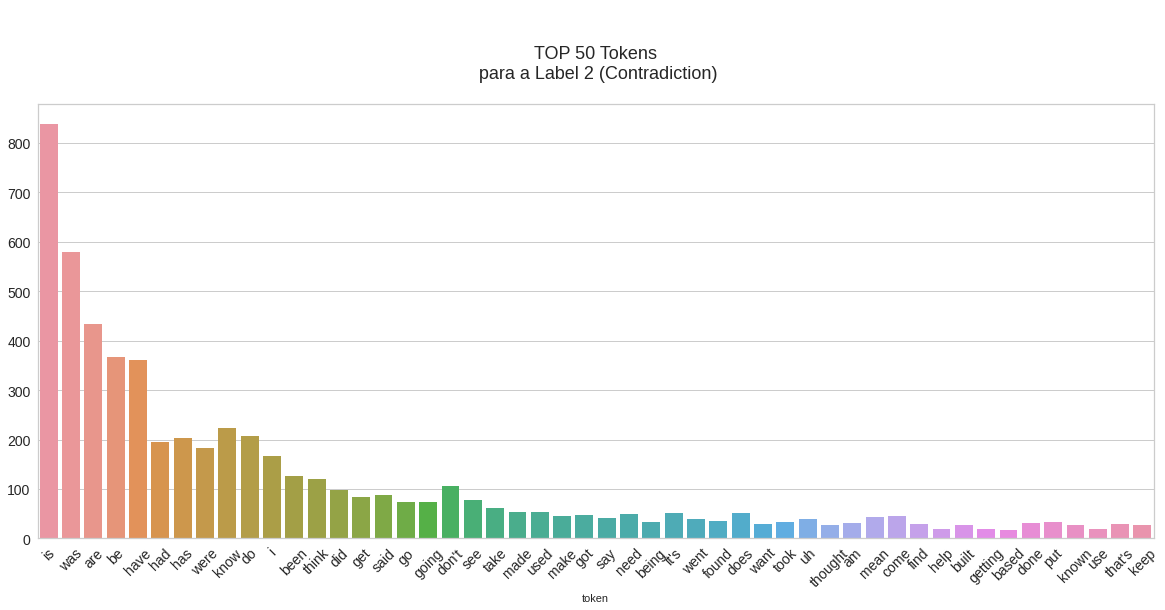

In [83]:
plt.figure(figsize=(20,8))
sns.barplot(x=df_label_by_token['Contradiction'].head(50).index, y=df_label_by_token['Contradiction'].head(50).values) 
plt.title('\n\nTOP 50 Tokens\n para a Label 2 (Contradiction)\n', size=18)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)
plt.show()

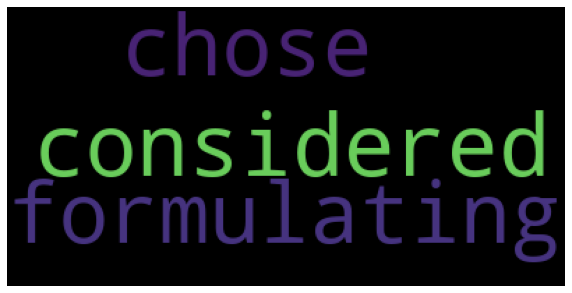

In [84]:
plt.figure(figsize=(10,10))
string_text = str(df_verbs2.loc[df_verbs2['Entailment']==1, 'token'].values).replace("'","").replace("[", "").replace("]","")
wordcloud = WordCloud(max_words=100, background_color="black", relative_scaling=.5).generate(string_text)
plt.imshow(wordcloud) #, interpolation='bilinear')
plt.axis("off")
plt.show()


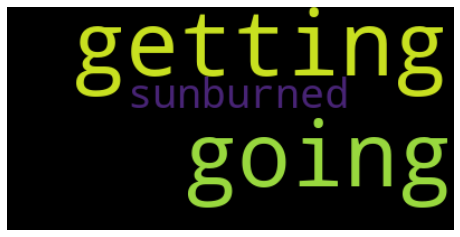

In [85]:
string_text = str(df_verbs2.loc[df_verbs2['Neutral']==1, 'token'].values).replace("'","").replace("[", "").replace("]","")
wordcloud = WordCloud(max_words=100, background_color="black").generate(string_text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

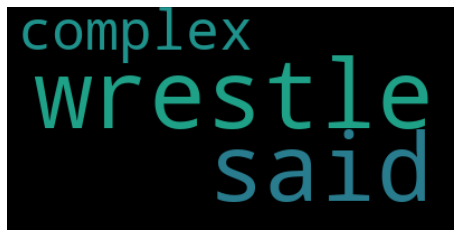

In [86]:
string_text = str(df_verbs2.loc[df_verbs2['Contradiction']==1, 'token'].values).replace("'","").replace("[", "").replace("]","")
wordcloud = WordCloud(max_words=100, background_color="black").generate(string_text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Semelhante ao resultado anterior, podemos constatar **há uma diferença sutil de frequência pros tokens em cada label**, mas devido a alta quantidade de tokens é difícil analisar manualmente os dados de forma mais detalhada. Por isso, optou-se por aplicar a **Técnica de Aprendizado Não Supervisionado** de **Clusterização**, para verificar se, ao definir **k=3**, obtemos **grupos de tokens que se concentram mais em uma label que outra**.

##### Clusterização

Foi levantada a hipótese inicial de que:
* As sentenças que contiverem Conectivos de __Relação Conclusiva__ (Logo, pois, portanto, por conseguinte, por isso, assim, sendo assim, por conta disso), Conectivos de __Relação Explicativa__ (Que, porque, pois),  Conectivos de __Relação Causal__ (Porque, por isso que, já que, uma vez que, visto que, visto como, pois), e Conectivos de __Relação Consecutiva__ (De forma que, tanto que, tal que, de maneira que, de modo que, de sorte que), tem maior propensão de indicar que a frase seja uma __Implicação__; 
* As que contiverem Conectivos de __Relação Adversativa__ (Mas, porém, todavia, contudo, no entanto, entretanto), Conectivos de __Relação Alternativa__ (Embora, ou…ou, ora…ora, quer… quer, seja…. seja), Conectivos de __Relação Concessiva__ ( Embora, ainda que, mesmo que, por mais que, apesar de que) e por fim alguns Conectivos de __Relação Comparativa__ ( Da mesma forma que, assim como, ao contrário de, diferentemente de, já), podem indicar a presença de __Contradição__;
* As que contiverem outros conectivos (ou não tiverem nenhum), são classificadas como __Neutro__.

Com isso, a **Técnica de Clusterização via k-medoids** será aplicada como uma forma de identificar grupos de tokens que talvez sejam significantes pra classificação das labels, conforme a hipótese acima.
Será definindo **k=3**, uma vez que o rótulo é conhecido.

A escolha do **Método de k-medoids** em detrimento de outras técnicas de **Clusterização Não Hierárquica**, foi baseada no fato deste método definir os centros de cada cluster com base em valores reais contidos na base, o que tornará possível uma Análise Qualitativa das linhas que de fato estão ao centro de seu grupo.

In [ ]:
nltk.help.upenn_tagset('CC')

CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet


In [ ]:
cv1 = CountVectorizer(analyzer= 'word', token_pattern= r'(\s\w+\'\w+\s)', max_df=0.98, min_df=0.005, ngram_range=(1,1))   #"[\w+\'\w+]+[^\s]" )
vectorizer1 = cv1.fit(df_train_eng['text'])
#vectorizer.vocabulary_
#vectorizer.get_feature_names()
BoW1 = cv1.transform(df_train_eng['text'])
df_BoW1 = pd.DataFrame(BoW1.toarray(), columns=vectorizer1.get_feature_names())
cv2 = CountVectorizer(analyzer= 'word', token_pattern= r'(?u)\b\w\w+\b', max_df=0.98, min_df=0.05, ngram_range=(1,2)) 
vectorizer2 = cv2.fit(df_union_eng['text'])
#vectorizer.vocabulary_
#vectorizer.get_feature_names()
BoW2 = cv2.transform(df_train_eng['text'])
df_BoW2 = pd.DataFrame(BoW2.toarray(), columns=vectorizer2.get_feature_names()) 

df_BoW_k = pd.concat([df_BoW1, df_BoW2], axis=1, ignore_index=False)
df_BoW_k = df_BoW_k.apply(lambda x: x.astype('bool'))
df_BoW_k['label'] = df_train_eng['label'].values  
#A delacração do valor precisa ser com base no atributo .values, pois do contrário o pandas usará a informação do índice como referência para atribuição de 
#valores linha a linha, e os índices possuem quebras na sequência devido terem passado por diversas etapas de processamento.


In [ ]:
df_BoW_k.iloc[:, :-1]

,can't,didn't,doesn't,don't,he's,i'll,i'm,i've,isn't,it's,...,up,was,we,well,were,when,will,with,yeah,you
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6865,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
6866,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6867,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
6868,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


###### Modelagem

In [ ]:
k=3
metric = "sqeuclidean"

    #Model definition
#O uso do parâmetro de inicialização atribuído com'k-medoids++', faz com que a definição das coordenadas 
#dos medoids iniciem geralmentes distantes uns dos outros, fazendo com que o algoritmo tenda a ter melhores 
#resultados que uma inicialização aleatórioa.
model = KMedoids(n_clusters=k, metric=metric, method='pam', init='k-medoids++', random_state=2)

    #Model traning
model.fit(df_BoW_k.iloc[:, :-1]) 

KMedoids(init='k-medoids++', max_iter=300, method='pam', metric='sqeuclidean',
         n_clusters=3, random_state=2)

Centro dos Clusters / Medóids: O retorno é a localização geométrica dos medoids, coordenadas do espaço vetorial multidimensional, neste caso 75 dimensões

In [ ]:
medoids = model.cluster_centers_
medoids

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

Retorna a POSIÇÃO dos índices (não os rótulos) dos Medóids no DataFrame usado para treinar o modelo.

In [ ]:
medoids_index = list(model.medoid_indices_)
medoids_index

[77, 2261, 110]

Lista ordenada do rótulo do cluster atribuído, linha a linha, pelo modelo treinado

In [ ]:
labels = model.labels_
labels

array([0, 1, 2, ..., 0, 0, 0])

Rótulos usados pelo modelo para diferenciar cada cluster

In [ ]:
rotulos= np.unique(labels)
rotulos

array([0, 1, 2])

Quantidade de eventos por cluster. 

In [ ]:
freq = pd.Series(labels)
pd.DataFrame({"Frequência do Cluster":freq.value_counts()}).head(None)

,Frequência do Cluster
1,3001
0,2203
2,1666


In [ ]:
df_treinado = df_BoW_k.copy()
df_treinado["K-Cluster"]= labels

Linhas referente ao centro (medoid) de cada cluster:

In [ ]:
df_medoid_k= df_treinado.iloc[medoids_index]      
df_medoid_k.head(77)

,can't,didn't,doesn't,don't,he's,i'll,i'm,i've,isn't,it's,...,we,well,were,when,will,with,yeah,you,label,K-Cluster
77,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
2261,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,1
110,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2,2


Como pode ser observado, o agrupamento atribuiu 2 clusters diferentes para a label 1 (Neutral), o que muito provavelmente se deve ao fato desta label englobar todas as categorias linguísticas que se encaixam como "outros", gerando certa ambiguidade pro modelo aprender.
Além disso o agupamento não identificou a label 2 (Contradiction).

In [ ]:
df_train_eng.iloc[medoids_index, :]

,index,id,premise,hypothesis,lang_abv,language,label,text,tokens,tokens_tag,qtd_verbs,verbs_tag,category_label,tokPrem,tokHip,qtd_tokens,qtd_tokens_prem,qtd_tokens_hip,qtdPrem/qtdHip,qtd_virgulas
77,143,b0ee325483,Finally the woman opened her eyes feebly,She opened her eyes,en,English,0,finally the woman opened her eyes feebly she ...,"[finally, the, woman, opened, her, eyes, feebl...","[(finally, RB), (the, DT), (woman, NN), (opene...",2.0,"[(opened, VBD), (opened, VBD)]",Entailment,"[Finally, the, woman, opened, her, eyes, feebly]","[She, opened, her, eyes]",11,7,4,1.750,0
2261,3986,4924f0c057,The National Association of State Information ...,The NA SIRE represents state chief information...,en,English,0,the national association of state information ...,"[the, national, association, of, state, inform...","[(the, DT), (national, JJ), (association, NN),...",6.0,"[(nasire, VBP), (represents, VBZ), (cio, VBP),...",Entailment,"[The, National, Association, of, State, Inform...","[The, NA, SIRE, represents, state, chief, info...",45,37,8,4.625,2
110,194,0ef9524ce7,Bauerstein,Alfred Inglethorp,en,English,2,bauerstein alfred inglethorp,"[bauerstein, alfred, inglethorp]","[(bauerstein, NN), (alfred, VBD), (inglethorp,...",1.0,"[(alfred, VBD)]",Contradiction,[Bauerstein],"[Alfred, Inglethorp]",3,1,2,0.500,0


Cálculo da medida de consenso **Índice Rand Ajustado**, onde a rotulagem perfeita é pontuada com 1.0, e a rotulagem discordante recebe uma pontuação mais baixas, podendo ser negativa ou próxima de zero:

In [ ]:
me.adjusted_rand_score(df_treinado["label"], df_treinado["K-Cluster"])

0.0014229234445065444

Cálculo da homogeneidade e da completude de cada cluster, sendo:
* **homogeneidade** : quando cada cluster contém apenas membros de uma única classe;
* **completude** : quando todos os membros de uma determinada classe são atribuídos ao mesmo cluster.

In [ ]:
me.homogeneity_score(df_treinado["label"], df_treinado["K-Cluster"])

0.0026257177569479454

In [ ]:
me.completeness_score(df_treinado["label"], df_treinado["K-Cluster"])

0.0026930996466182377

A tabela cruzada abaixo torna evidente que o Agrupamento não correspondeu aos rótulos pré-existentes.

In [ ]:
pd.crosstab(df_treinado["K-Cluster"], df_treinado.label)

label,0,1,2
K-Cluster,,,
0,765,725,713
1,1014,1017,970
2,648,424,594


Cálculo do **Coeficiente de Silhueta Média** para cada cluster

Resultado obtido antes do Ajuste da Medida de Dissimilaridade, ao usar a configuração default da Distância Euclidiana:
- Silhueta Média para Cluster 0: -0.05 +- 0.0012
- Silhueta Média para Cluster 1: 0.05 +- 0.0026
- Silhueta Média para Cluster 2: 0.22 +- 0.0012

In [ ]:
cof_silh = me.silhouette_samples(df_BoW_k.iloc[:, :-1], labels)

print('     Para a Medida Sqeuclidean:')
for ki in range(k):
    print("Silhueta Média para Cluster {:}: {:.2f} +- {:.4f}".format(ki, 
                                                                   np.mean(cof_silh[labels==ki]),
                                                                   np.std(cof_silh[labels==ki]/np.sum(labels==ki)**.5)))  

print("\nO melhor valor é 1 e o pior valor é -1. Valores próximos de 0 indicam clusters sobrepostos.")

     Para a Medida Sqeuclidean:
Silhueta Média para Cluster 0: 0.01 +- 0.0004
Silhueta Média para Cluster 1: -0.03 +- 0.0008
Silhueta Média para Cluster 2: 0.12 +- 0.0008

O melhor valor é 1 e o pior valor é -1. Valores próximos de 0 indicam clusters sobrepostos.


**Ajuste do hiperparâmetro** correspondente à **medida de dissimilaridade**, através da comparação destas medidade pelo **índice de Calinski-Harabasz**, também conhecido como **Critério da Razão de Variância**.

In [ ]:
modelos = [] 
medidas = ['euclidean', 'l2', 'l1', 'manhattan', 
           'cityblock', 'braycurtis', 'canberra', 
           'chebyshev', 'correlation', 'cosine', 
           'hamming', 'mahalanobis', 'matching',
           'minkowski', 'rogerstanimoto', 'russellrao',
           'seuclidean', 'sokalmichener', 'sokalsneath',
           'sqeuclidean', 'yule', 'wminkowski',
           'nan_euclidean', 'haversine']  

for i in tqdm(range(len(medidas))):
    try:
        imodel = KMedoids(n_clusters=8, metric=medidas[i], init='k-medoids++', max_iter = 300, method='pam', random_state=2)
        imodel.fit(df_BoW_k.iloc[:, :-1])
        modelos.append(imodel)
    except: 
        continue 

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
metricas = []
for a in range(len(modelos)):
    metrica = me.calinski_harabasz_score(df_BoW_k.iloc[:, :-1], modelos[a].labels_)
    metricas.append(metrica)

for b in tqdm(range(len(modelos))):
    print("O Índice Calinski-Harabasz da Medida {:} é: {:.4f}".format(modelos[b].metric, metricas[b]))

print("\nUma pontuação mais alta se refere a um modelo com clusters mais bem definidos.")

  0%|          | 0/22 [00:00<?, ?it/s]

O Índice Calinski-Harabasz da Medida euclidean é: 159.7922
O Índice Calinski-Harabasz da Medida l2 é: 159.7922
O Índice Calinski-Harabasz da Medida l1 é: 156.8540
O Índice Calinski-Harabasz da Medida manhattan é: 156.8540
O Índice Calinski-Harabasz da Medida cityblock é: 156.8540
O Índice Calinski-Harabasz da Medida braycurtis é: 111.6234
O Índice Calinski-Harabasz da Medida canberra é: 156.8540
O Índice Calinski-Harabasz da Medida chebyshev é: 3.6501
O Índice Calinski-Harabasz da Medida correlation é: 18.2824
O Índice Calinski-Harabasz da Medida cosine é: 121.9220
O Índice Calinski-Harabasz da Medida hamming é: 156.8540
O Índice Calinski-Harabasz da Medida mahalanobis é: 131.6572
O Índice Calinski-Harabasz da Medida matching é: 156.8540
O Índice Calinski-Harabasz da Medida minkowski é: 159.7922
O Índice Calinski-Harabasz da Medida rogerstanimoto é: 158.5900
O Índice Calinski-Harabasz da Medida russellrao é: 44.7107
O Índice Calinski-Harabasz da Medida seuclidean é: 153.8968
O Índice C

Conforme os resultados acima, a medida de dissimilaridade com maior **Índice Calinski-Harabasz** foi a **Distância Sqeuclidean=368.6** .

Ver:https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.seuclidean.html#scipy.spatial.distance.seuclidean

Usando a técnica de Redução de Dimensionalidade TSNE para **Visualização dos Dados** após a aplicação do modelo.

In [ ]:
tsne= TSNE( n_components = 2, random_state = 2 ).fit_transform(df_treinado)
df_tsn = pd.DataFrame(data={"1d":list(tsne[:,0]), "2d": list(tsne[:, 1])})                                                                 

<Figure size 1296x720 with 0 Axes>

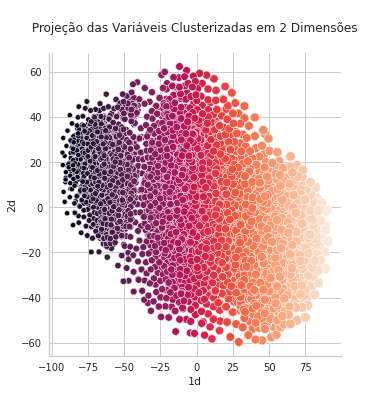

In [ ]:
fig = plt.figure(figsize=(18,10))
#sb.set_palette(sb.color_palette("crest", as_cmap=True)) 
sns.relplot(x="1d" , y='2d', data=df_tsn, legend=False, hue="1d", size="1d", palette=sns.color_palette("rocket", as_cmap=True))  #, style="1d", )
plt.title("\nProjeção das Variáveis Clusterizadas em 2 Dimensões\n")           
plt.show()

Devido aos resultados inconclusivos obtidos acima, será realizada a aplicação do **Método de Transformação PCA** para **Redução de Dimensionalidade** do Dataset.

###### Modelagem com PCA

Uma vez que será aplicada uma técnica pra redução das dimensões, não há necessidade de limitar a vetorização do texto para as palavras mais frequentes para reduzir o dataset, pois o próprio PCA se encarregará de reduzí-lo. Por isso será feita uma nova vetorização considerando todos os tokens presentes no texto.

In [21]:
cv_pca1 = CountVectorizer(analyzer= 'word', token_pattern= r'(\s\w+\'\w+\s)', ngram_range=(1,1))   #"[\w+\'\w+]+[^\s]" )
vectorizer_pca1 = cv_pca1.fit(df_train_eng['text'])
#vectorizer.vocabulary_
#vectorizer.get_feature_names()
BoW_pca1 = cv_pca1.transform(df_train_eng['text'])
cv_pca1 = 0

df_BoW_pca1 = pd.DataFrame(BoW_pca1.toarray(), columns=vectorizer_pca1.get_feature_names())
vectorizer_pca1 = 0

In [22]:
cv_pca2 = CountVectorizer(analyzer= 'word', token_pattern= r'(?u)\b\w\w+\b', ngram_range=(1,2)) 
vectorizer_pca2 = cv_pca2.fit(df_train_eng['text'])
#vectorizer.vocabulary_
#vectorizer.get_feature_names()
BoW_pca2 = cv_pca2.transform(df_train_eng['text'])
cv_pca2

df_BoW_pca2 = pd.DataFrame(BoW_pca2.toarray(), columns=vectorizer_pca2.get_feature_names())
vectorizer_pca1 = 0

In [23]:
df_BoW_full = pd.concat([df_BoW_pca1, df_BoW_pca2], axis=1, ignore_index=False)

#Redeclarando a variável para que não ocupe tanto espaço em memória
df_BoW_pca1 = pd.DataFrame() 
df_BoW_pca2 = pd.DataFrame() 

df_BoW_full

,1980's,90's,abc's,abortion's,act's,administration's,administrator's,adrian's,adrin's,advocate's,affirm's,agency's,agra's,ahkenaten's,aid's,america's,ann's,anthem's,antique's,anyone's,apartheid's,arc's,architect's,area's,aren't,association's,attorney's,autopilot's,baby's,ball'll,bank's,bar's,barenakedino's,bartlett's,barton's,basia's,basketball's,bellagio's,bergman's,bible's,bob's,borrower's,boss's,brooke's,brown's,bush's,ca'daan,caesar's,can't,carpenter's,carrey's,cathedral's,ceo's,cfo's,channel's,chavez's,che's,chicago's,children's,china's,christ's,city's,claus's,client's,clinton's,clooney's,coalition's,column's,commission's,company's,cook's,corbett's,could've,couldn't,country's,county's,court's,d'azur,d'extremadura,d'honneur,dagger's,daughter's,david's,dealer's,decedent's,decision's,delhi's,deng's,derry's,devil's,didn't,disney's,dod's,doesn't,dog's,domingo's,don't,dsm's,dubbawya's,dublin's,dunn's,dyson's,economist's,edinburgh's,employee's,epa's,era's,erlenborn's,eve's,everybody's,everyone's,facility's,family's,farmer's,father's,fda's,fetus's,filter's,finkelstein's,formentera's,france's,frankenheimer's,fraser's,fray's,friend's,funchal's,function's,fwi's,galileo's,gallery's,gao's,gaulle's,germany's,get's,gladstone's,globalization's,god's,gododdin's,goodman's,government's,governor's,granddaddy's,green's,group's,ha'etim,hadn't,hanson's,harvelle's,hasn't,haussmann's,haven't,hca's,he'd,he'll,he's,hearst's,heather's,heaven's,hell's,herod's,hodgkin's,hoover's,hotels'a,hour's,household's,how's,hsia's,i'd,i'll,i'm,i've,ibiza's,idpa's,ii's,india's,individual's,industry's,inglethorp's,insured's,insurer's,internet's,ireland's,island's,islands'meaning,isn't,israel's,israeli's,istanbul's,it'd,it'll,it's,jack's,james's,japan's,jerusalem's,jesus's,john's,jon's,jury's,kal's,kerr's,kid'll,kid's,king's,l'oeuvre,labor's,landsburg's,leonardo's,let's,liddy's,liggett's,light's,lincoln's,lingett's,loan's,louisville's,lsc's,m's,ma'am,macau's,madrid's,mae's,malaya's,man's,martha's,mary's,maryland's,mcdonald's,mci's,men's,microbe's,microsoft's,minister's,moment's,monster's,montana's,mother's,mozart's,mumbai's,mustn't,napoleon's,narrator's,natalia's,nation's,nbc's,nean's,nhtsa's,night's,nist's,nobody's,...,you tended,you thank,you that,you the,you there,you they,you things,you think,you thirsty,you thorough,you thought,you thoughts,you to,you tomorrow,you too,you totally,you tried,you trust,you try,you tuppence,you turned,you typically,you um,you under,you underestimate,you understand,you use,you ve,you very,you visit,you wake,you want,you wanted,you watch,you wear,you well,you went,you were,you what,you where,you whether,you who,you why,you will,you with,you won,you wonder,you working,you would,you wouldn,you you,you your,young,young age,young and,young children,young girl,young king,young lady,young life,young man,young not,young simpson,young skins,young to,young turks,young wealthies,young woman,young women,younger,younger generation,younger girl,younger people,youngest,youngest mosque,your,your activities,your advice,your age,your ailments,your approach,your assistance,your back,your best,your biography,your boss,your bushes,your calls,your car,your cash,your chances,your children,your color,your comments,your computer,your contemporaries,your criticism,your data,your decision,your decisions,your dedication,your destination,your drug,your eggshell,your entire,your eyes,your family,your farewell,your feeling,your feelings,your friends,your gear,your girl,your hand,your heand,your help,your home,your house,your husband,your identity,your issues,your job,your kids,your kiln,your last,your lawn,your leisure,your life,your little,your lives,your luck,your man,your marriage,your medical,your memories,your men,your mind,your mistress,your money,your new,your newspapers,your normal,your nose,your office,your only,your opinion,your out,your own,your paper,your parents,your pay,your personal,your potential,your prey,your priorities,your private,your punch,y

In [24]:
df_BoW_full.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6870 entries, 0 to 6869
Columns: 81680 entries,  1980's  to υrt and
dtypes: int64(81680)
memory usage: 4.2 GB


In [25]:
df_BoW_full = df_BoW_full.apply(lambda x: x.astype('bool'))
df_BoW_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6870 entries, 0 to 6869
Columns: 81680 entries,  1980's  to υrt and
dtypes: bool(81680)
memory usage: 535.1 MB


In [ ]:
df_BoW_full['label'] = df_train_eng['label'].values  
#A delacração do valor precisa ser com base no atributo .values, pois do contrário o pandas usará a informação do índice como referência para atribuição de 
#valores linha a linha, e os índices possuem quebras na sequência devido terem passado por diversas etapas de processamento.

pca_n = PCA(random_state = 8 ) #n_components == min(n_samples, n_features) - 1
df_pca_n = pd.DataFrame(pca_n.fit_transform(df_BoW_full.iloc[:, :-1])) #.T
df_pca_n.info() 

In [ ]:
df_pca_n.shape

In [ ]:
df_pca_n['Var. Relativa %'] = pca_n.explained_variance_ratio_*100
df_pca_n['Var. Acumulada %'] = df_pca_n['Var. Relativa %'].cumsum()

#Proporção de 1 coluna em relação a quantidade total
df_pca_n['Qtd. Coluna Relativa %'] = np.round(1/df_pca_n.shape[0]*100, 2)

#Proporção acumulada
df_pca_n['Qtd. Coluna Acumulada %'] = df_pca_n['Qtd. Coluna Relativa %'].cumsum()
df_pca_n.head()

In [ ]:
plt.plot(df_pca_n['Var. Relativa %'][:70])
plt.title("\nGráfico da Variabilidade dos Atributos\n")
plt.xlabel("\nComponente de índice N")
plt.ylabel("Var. Relativa %\n")
plt.show()

No gráfico acima é possível observar que os primeiros atributos carregam a maior parte da variabilidade dos dados, tendo uma queda abrupta da representatividade antes mesmo do décimo atributo. 

Abaixo foi feito um gráfico num intervalo reduzido, fatiando este trecho da curva. 

In [ ]:
6870/2200

In [ ]:
#fig, (barras, escala)= plt.subplots(nrows= 2, ncols=1,figsize=(10, 5)) 
fig = plt.figure(figsize=(16, 5)) 
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[40, 1])  
barras = fig.add_subplot(spec[0])

barras.set_ylabel('\nVar. Relativa % Atributos\n\n')
barras.bar(list(range(23)), df_pca_n.loc[list(range(23)), 'Var. Relativa %'], color='c')
barras.set_xlabel('Colunas do índice 0 a 21')
barras.set_xticks(list(range(22)))

linha= barras.twinx()
linha.set_ylabel('Var. Acumulada %', color='tomato')
linha.plot(list(range(23)), df_pca_n.loc[list(range(23)), 'Var. Acumulada %'], color='red', linewidth=3, marker='s', markersize=8) 
linha.tick_params(axis='y', labelcolor='tomato')

escala =  fig.add_subplot(spec[1])

#escala.set_xticks(df_pca_n.loc[list(range(22)), 'Qtd. Coluna Acumulada %'])
escala.set_xlabel('\nQtd. Acumulada % dos Atributos de índice 0 a 21 \n\n')
escala.set_xlim([-1, 3.12])

plt.subplots_adjust(hspace=0.4)

plt.title('\nGráfico de Pareto\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')
plt.show()

Baseado no Príncipio de Escassez do Fator (também conhecido como **Regra do 80/20**) do **Economista Vilfredo Pareto**, foi feito o gráfico comparativo acima, contendo no Eixo Y Primário (Esquerda) a **Variabilidade % dos Atributos**, e no Eixo Y Secundário (Direita) a **Proporção acumulada** destes, e na Escala do Eixo X a Quantidade proporcional de atributos variando das colunas de índice 0 a 21. Por mais que a proporção não seja de 80/20, o gráfico demonstra que **80% da variabilidade** total dos dados **está concentrada em** aproximadamente **3.12% do total das colunas.**

Portanto, foi definido que **22** é o número ótimo de componentes para este conjunto de dados. 

In [ ]:
n_components = 22
pca1 = PCA(n_components= n_components, random_state = 4 )
#Realizando a transformação na matriz transposta, para manter a compatibilidade das linhas e ser possível comparar com
#os a base rotulada
pca1.fit_transform(df_BoW_full.iloc[:, :-1].T) 
df_BoW_full = pd.DataFrame()  #Redeclarando a variável para que não ocupe tanto espaço em memória

df_pca = pd.DataFrame(pca1.components_.T)
df_pca.head(None) 

Agrupamento após a Redução da Dimensionalidade

In [ ]:
k=3
metric = "sqeuclidean" #"euclidean"

    #Model definition
#O uso do parâmetro de inicialização atribuído com'k-medoids++', faz com que a definição das coordenadas 
#dos medoids iniciem geralmentes distantes uns dos outros, fazendo com que o algoritmo tenda a ter melhores 
#resultados que uma inicialização aleatórioa.
model_pca = KMedoids(n_clusters=k, metric=metric, method='pam', init='k-medoids++', random_state=2)

    #Model traning
model_pca.fit(df_pca) 

Centro dos Clusters / Medóids: O retorno é a localização geométrica dos medoids, coordenadas do espaço vetorial multidimensional, neste caso 22 dimensões

In [ ]:
medoids_pca = model_pca.cluster_centers_

Retorna a POSIÇÃO dos índices (não os rótulos) dos Medóids no DataFrame usado para treinar o modelo.

In [ ]:
medoids_index_pca = list(model_pca.medoid_indices_)

Lista ordenada do rótulo do cluster atribuído, linha a linha, pelo modelo treinado

In [ ]:
labels_pca = model_pca.labels_

Rótulos usados pelo modelo para diferenciar cada cluster

In [ ]:
rotulos_pca= np.unique(labels_pca)

Quantidade de eventos por cluster. 

In [ ]:
freq = pd.Series(labels_pca)
pd.DataFrame({"Frequência do Cluster":freq.value_counts()}).head(None)

In [ ]:
df_treinado_pca = pd.concat([df_pca.copy(), df_BoW_full[['label']]], axis=1, ignore_index=False)
df_treinado_pca["K-Cluster"]= labels_pca
df_treinado_pca

Linhas referente ao centro (medoid) de cada cluster:

In [ ]:
df_medoid_k_pca= df_treinado_pca.iloc[medoids_index_pca]
df_medoid_k_pca.head(77)

Desta vez, o agrupamento atribuiu 2 clusters diferentes para a label 2 (Contradiction), ao contrário do agrupamento sem PCA que fez o mesmo porém para a label 1 (Neutral). O modelo desta vez não soube identificar a label 1.

Cálculo da medida de consenso **Índice Rand Ajustado**, onde a rotulagem perfeita é pontuada com 1.0, e a rotulagem discordante recebe uma pontuação mais baixas, podendo ser negativa ou próxima de zero:

Base Vetorizada Parcial (apenas tokens mais frequentes, originalmente 75 features antes da redução pelo PCA):
* Distância Euclidiana:  0.0000063 e Distância Sqeuclidean: 0.0005749

Base Vetorizada Completa (todos os tokens, originalmente 80403 features antes da redução pelo PCA):
* Distância Sqeuclidean: 0.0029

In [ ]:
me.adjusted_rand_score(df_treinado_pca["label"], df_treinado_pca["K-Cluster"])

Cálculo da homogeneidade e da completude de cada cluster, sendo:
* **homogeneidade** : quando cada cluster contém apenas membros de uma única classe;
* **completude** : quando todos os membros de uma determinada classe são atribuídos ao mesmo cluster.

**Homogeneidade**: 

Base Vetorizada Parcial (apenas tokens mais frequentes, originalmente 75 features antes da redução pelo PCA)
* Distância Euclidiana:  0.000103
* Distância Sqeuclidean: 0.000854

Base Vetorizada Completa (todos os tokens, originalmente 80403 features antes da redução pelo PCA):
* Distância Sqeuclidean: 0.0037

In [ ]:
me.homogeneity_score(df_treinado_pca["label"], df_treinado_pca["K-Cluster"])

**Completude**:

Base Vetorizada Parcial (apenas tokens mais frequentes, originalmente 75 features antes da redução pelo PCA)
* Distância Euclidiana:  0.000157
* Distância Sqeuclidean: 0.000935

Base Vetorizada Completa (todos os tokens, originalmente 80403 features antes da redução pelo PCA):
* Distância Sqeuclidean: 0.0055

In [ ]:
me.completeness_score(df_treinado_pca["label"], df_treinado_pca["K-Cluster"])

A tabela cruzada abaixo torna evidente os resultados da homogeneidade e completudo dos clusters, ambas muito próximas de zero (por mais que tenha sido melhor que os resultados ao usar a Distância Euclidiana).

In [ ]:
pd.crosstab(df_treinado_pca["K-Cluster"], df_treinado_pca.label)

Ainda assim, mesmo com as métricas acima estando muito próximas de zero, é possível observar que o uso da base de dados completa, com a vetorização de todos os 80403 tokens, obteve um desempenho acima da base reduzida pelos tokens mais frequentes, evidênciando que desconsiderar os tokens pela frequência (tanto pela baixa quanto pela alta), resulta na perca de informação.

Cálculo do **Coeficiente de Silhueta Média** para cada cluster

**Base Vetorizada Parcial:**

Resultado obtido antes do Ajuste da Medida de Dissimilaridade, ao usar a configuração default da Distância Euclidiana:
- Silhueta Média para Cluster 0: 0.15 +- 0.0040
- Silhueta Média para Cluster 1: 0.05 +- 0.0003
- Silhueta Média para Cluster 2: 0.07 +- 0.0012

Resultado pela  Distância de Sqeuclidean (após Ajuste da Medida de Dissimilaridade):
- Silhueta Média para Cluster 0: 0.01 +- 0.0006
- Silhueta Média para Cluster 1: 0.06 +- 0.0005
- Silhueta Média para Cluster 2: 0.14 +- 0.0039

In [ ]:
cof_silh = me.silhouette_samples(df_pca, labels_pca)

print("**Base Vetorizada Completa**")
for ki in range(k):
    print("Silhueta Média para Cluster {:}: {:.2f} +- {:.4f}".format(ki, 
                                                                   np.mean(cof_silh[labels_pca==ki]),
                                                                   np.std(cof_silh[labels_pca==ki]/np.sum(labels_pca==ki)**.5)))  

print("\nO melhor valor é 1 e o pior valor é -1. Valores próximos de 0 indicam clusters sobrepostos.")

Ajuste do hiperparâmetro correspondente à medidas de dissimilaridade, através da comparação destas medidade pelo índice de Calinski-Harabasz, também conhecido como Critério da Razão de Variância.

In [ ]:
modelos = []
medidas = ['euclidean', 'l2', 'l1', 'manhattan', 
           'cityblock', 'braycurtis', 'canberra', 
           'chebyshev', 'correlation', 'cosine', 
           'hamming', 'mahalanobis', 'matching',
           'minkowski', 'rogerstanimoto', 'russellrao',
           'seuclidean', 'sokalmichener', 'sokalsneath',
           'sqeuclidean', 'yule', 'wminkowski',
           'nan_euclidean', 'haversine']

for i in tqdm(range(len(medidas))):
    try:
        imodel = KMedoids(n_clusters=8, metric=medidas[i], init='k-medoids++', max_iter = 300, method='pam', random_state=2)
        imodel.fit(df_pca)
        modelos.append(imodel)
    except:
        continue

In [ ]:
metricas = []
for a in range(len(modelos)):
    metrica = me.calinski_harabasz_score(df_pca, modelos[a].labels_)
    metricas.append(metrica)

for b in tqdm(range(len(modelos))):
    print("O Índice Calinski-Harabasz da Medida {:} é: {:.4f}".format(modelos[b].metric, metricas[b]))

print("\nUma pontuação mais alta se refere a um modelo com clusters mais bem definidos.")

Conforme os resultados acima, a medida de dissimilaridade com maior **Índice Calinski-Harabasz** foi a **Distância Sqeuclidean = 230.3** .

Usando a técnica de Redução de Dimensionalidade TSNE para visualização do Dataset após a aplicação do modelo.

In [ ]:
tsne= TSNE( n_components = 2, random_state = 2 ).fit_transform(df_treinado_pca)
df_tsn_pca = pd.DataFrame(data={"1d":list(tsne[:,0]), "2d": list(tsne[:, 1])})                                                                 

In [ ]:
fig = plt.figure(figsize=(18,10))
#sb.set_palette(sb.color_palette("crest", as_cmap=True)) 
sns.relplot(x="1d" , y='2d', data=df_tsn_pca, legend=False, hue="1d", size="1d", palette=sns.color_palette("rocket", as_cmap=True))  #, style="1d", )
plt.title("\nProjeção das Variáveis Clusterizadas em 2 Dimensões\n")           
plt.show()

Por mais que a **visualização gráfica** da projeção das variáveis em duas dimensões, tenha resultado em **clusters aparentemente definidos**, os resultados obtidos para o Índice Rand Ajustado, Homogeneidade e Completude foram todos muito próximos de zero antes e depois da aplicação do PCA.

###### Modelagem PCA + k>3

Como última tentativa, será feito mais um agrupamento (com a Transformação PCA), porém desta vez definindo k de acordo com o **Método de Elbow**. O intuito desta tentativa é que seja identificado pelo menos 1 centro de cluster (medoids) para cada label, pois todas as tentativas acima resultaram na identificação de apenas 2 das 3 labels já rotuladas no dataset. Posteriormente será feita a análise do resultado numa tabela cruzada para consolidar as ramificações dos cluster que se concentrarem numa das 3 labels existentes.

Definição de K

In [ ]:
wcss = []
for i in tqdm(range(1, 50)):
    tmodel = KMedoids(n_clusters=i+1, metric='sqeuclidean', init='k-medoids++', max_iter = 300, method='pam', random_state=2)
    tmodel.fit(df_pca)
    wcss.append(tmodel.inertia_)

In [ ]:
len(wcss)

In [ ]:
plt.plot(range(1, 49+1), wcss)
plt.title("Método de Elbow")
plt.xlabel("\nk Cluters")
plt.ylabel("WCSS\n")
plt.show()

 O gráfico acima nos mostra uma curva decrescente suave,  mas um pouco mais acentuado entre 10 e 20. Desta forma, definiremos **k=12**.

In [ ]:
k=15
metric = "sqeuclidean" #"euclidean"

    #Model definition
#O uso do parâmetro de inicialização atribuído com'k-medoids++', faz com que a definição das coordenadas 
#dos medoids iniciem geralmentes distantes uns dos outros, fazendo com que o algoritmo tenda a ter melhores 
#resultados que uma inicialização aleatórioa.
model_k = KMedoids(n_clusters=k, metric=metric, method='pam', init='k-medoids++', random_state=2)

    #Model traning
model_k.fit(df_pca) 

In [ ]:
medoids_k = model_k.cluster_centers_

In [ ]:
medoids_index_k = list(model_k.medoid_indices_)

In [ ]:
labels_k = model_k.labels_

In [ ]:
rotulos_k= np.unique(labels_k)

Quantidade de eventos por cluster. 

In [ ]:
freq = pd.Series(labels_k)
pd.DataFrame({"Frequência do Cluster":freq.value_counts()}).head(None)

In [ ]:
df_treinado_k = pd.concat([df_pca.copy(), df_BoW_full[['label']]], axis=1, ignore_index=False)
df_treinado_k["K-Cluster"]= labels_k
df_treinado_k

Linhas referente ao centro (medoid) de cada cluster:

In [ ]:
df_medoid_k= df_treinado_k.iloc[medoids_index_k]
df_medoid_k.head(77)

Cálculo da homogeneidade e da completude de cada cluster, sendo:
* **homogeneidade** : quando cada cluster contém apenas membros de uma única classe;
* **completude** : quando todos os membros de uma determinada classe são atribuídos ao mesmo cluster.

In [ ]:
me.homogeneity_score(df_treinado_k["label"], df_treinado_k["K-Cluster"])

In [ ]:
me.completeness_score(df_treinado_k["label"], df_treinado_k["K-Cluster"])

A tabela cruzada abaixo torna evidente que o Agrupamento não correspondeu aos rótulos pré-existentes.

In [ ]:
pd.crosstab(df_treinado_k["K-Cluster"], df_treinado_k.label)

In [ ]:
df_view = pd.get_dummies(data=df_treinado_k, prefix='label', columns=['label']) 

In [ ]:
df_view.iloc[:, -4:].groupby(by='K-Cluster').sum()

Cálculo do Coeficiente de Silhueta Média para cada cluster

In [ ]:
cof_silh = me.silhouette_samples(df_pca.iloc[:, :-1], labels_k)

print('     Para a Medida Sqeuclidean:')
for ki in range(k):
    print("Silhueta Média para Cluster {:}: {:.2f} +- {:.4f}".format(ki, 
                                                                   np.mean(cof_silh[labels_k==ki]),
                                                                   np.std(cof_silh[labels_k==ki]/np.sum(labels_k==ki)**.5)))  

print("\nO melhor valor é 1 e o pior valor é -1. Valores próximos de 0 indicam clusters sobrepostos.")

In [ ]:
tsne= TSNE( n_components = 2, random_state = 2 ).fit_transform(df_treinado_k)
df_tsn_k = pd.DataFrame(data={"1d":list(tsne[:,0]), "2d": list(tsne[:, 1])})                                                                 

In [ ]:
fig = plt.figure(figsize=(18,10))
#sb.set_palette(sb.color_palette("crest", as_cmap=True)) 
sns.relplot(x="1d" , y='2d', data=df_tsn_k, legend=False, hue="1d", size="1d", palette=sns.color_palette("rocket", as_cmap=True))  #, style="1d", )
plt.title("\nProjeção das Variáveis Clusterizadas em 2 Dimensões\n")           
plt.show()

Após esta tentativa, vemos que **mesmo definindo um valor de k maior que os rótulos pré-existentes** na base, as métricas de **homogeneidade** e **completude NÃO melhoraram de forma significativa**, tampouco o valor da silhueta de cada cluster. O agrupamento do dataset treinado, agrupando as labels por cada rótulo oriundo do treinamento do modelo, tornou possível visualizar a **distribuição quase uniforme dos rótulos**, mostrando que **o modelo não soube identificar nenhum grupo de palavras** que fosse predominante numa das 3 labels existentes, **desvalidando a hipótese inicial sobre a Classe Gramatical de Conjunções**.

#### Similaridade Léxica

Nesta etapa a extração será feito uma Feature para a **Medida de Similaridade** de Jaccard entre a **Premissa e a Hipótese**.

O **Score da similaridade de Jaccard** está no **intervalo de 0 a 1**, sendo que se os dois documentos forem idênticos, a similaridade de Jaccard será 1.

In [17]:
def jaccard_similarity(doc1, doc2):
    # Transformando a lista de tokens de cada doc num conjunto do tipo set()
    conjunto1 = set(doc1.split()) 
    conjunto2 = set(doc2.split())
    
    # Encontrando a interseção de elementos entre os conjuntos
    intersection = conjunto1.intersection(conjunto2)

    # Fazendo a união entre os conjuntos, tirando assim a duplicidade de elementos
    union = conjunto1.union(conjunto2)
        
    # Calculando a similaridade de Jaccard, que consiste na razão entre a quantidade de elementos da interseção 
    #e a quantidade de elementos da união dos conjuntos
    try:
        return float(len(intersection)) / len(union)
    except ZeroDivisionError:
        return 0   

In [18]:
df_train_eng['score_similaridade_lex'] = df_train_eng.apply(lambda x: jaccard_similarity(x['premise'], x['hypothesis']), axis=1)
df_union_eng['score_similaridade_lex'] = df_union_eng.apply(lambda x: jaccard_similarity(x['premise'], x['hypothesis']), axis=1)

df_train_eng['score_similaridade_lex']

0       0.437500
1       0.136364
2       0.210526
3       1.000000
4       0.083333
          ...   
6865    0.114286
6866    0.857143
6867    0.000000
6868    0.400000
6869    0.125000
Name: score_similaridade_lex, Length: 6870, dtype: float64

In [19]:
df_sim = df_train_eng.copy()
df_sim['label'] = df_sim.label.apply(func_de_para) 
df_sim.loc[:, ['label', 'score_similaridade_lex']].groupby(by='label').describe()

score_similaridade_lex                                     \
                               count      mean       std  min       25%   
label                                                                     
Contradiction                 2277.0  0.179128  0.140596  0.0  0.083333   
Entailment                    2427.0  0.248253  0.157473  0.0  0.136364   
Neutral                       2166.0  0.156418  0.125043  0.0  0.069166   

                                             
                    50%       75%       max  
label                                        
Contradiction  0.142857  0.250000  1.000000  
Entailment     0.222222  0.333333  1.000000  
Neutral        0.128619  0.214286  0.857143

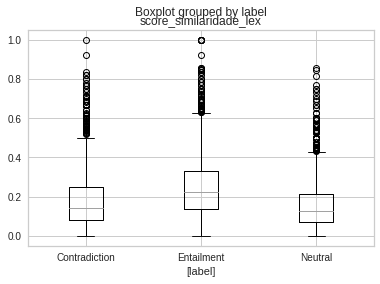

In [20]:
df_sim.loc[:, ['label', 'score_similaridade_lex']].boxplot(by='label')

### Ciclo 4: Combinação de Features

Neste último ciclo de modelagem, será feito o treinamento dos modelos de classificação, sobre a combinação das principais Features extraídas no ciclo anterior

#### Feature Tokens

Serão criadas 2 features que exprimem a vetorização de todos os tokens contidos na base, pela técnica de **Análise de Componentes Principais**.

<img src="CapturaPCA.jpg", width="300", height= "300">

In [96]:
cv_pca1 = CountVectorizer(analyzer= 'word', token_pattern= r'(\s\w+\'\w+\s)', max_df=0.98, min_df=0.005, ngram_range=(1,1))   #"[\w+\'\w+]+[^\s]" )
vectorizer_pca1 = cv_pca1.fit(df_train_eng['text'])
#vectorizer.vocabulary_
#vectorizer.get_feature_names()
BoW_pca1 = cv_pca1.transform(df_train_eng['text'])
df_BoW_pca1 = pd.DataFrame(BoW_pca1.toarray(), columns=vectorizer_pca1.get_feature_names())

cv_pca1 = 0
vectorizer_pca1 = 0

In [97]:
cv_pca2 = CountVectorizer(analyzer= 'word', token_pattern= r'(?u)\b\w\w+\b', max_df=0.98, min_df=0.005, ngram_range=(1,2)) 
vectorizer_pca2 = cv_pca2.fit(df_train_eng['text'])
#vectorizer.vocabulary_
#vectorizer.get_feature_names()
BoW_pca2 = cv_pca2.transform(df_train_eng['text'])
df_BoW_pca2 = pd.DataFrame(BoW_pca2.toarray(), columns=vectorizer_pca2.get_feature_names()) 

cv_pca2 = 0
vectorizer_pca2 = 0

In [98]:
df_BoW_union = pd.concat([df_BoW_pca1, df_BoW_pca2], axis=1, ignore_index=False)
df_BoW_pca1 = pd.DataFrame()
df_BoW_pca2 = pd.DataFrame()
df_BoW_union

,can't,didn't,doesn't,don't,he's,i'll,i'm,i've,isn't,it's,that's,there's,they're,wasn't,we're,won't,wouldn't,you're,000,100,12,able,able to,about,about it,about the,across,across the,act,activities,actually,after,after the,again,against,age,agencies,agency,ago,air,all,all of,all the,almost,along,already,also,although,always,am,america,among,amount,an,ancient,and,and and,and it,and not,and other,and that,and the,and then,and they,and uh,and we,and you,another,any,anyone,anything,are,are no,are not,are the,are you,around,around the,as,as the,as well,asked,at,at all,at least,at the,available,away,back,bad,based,be,because,because it,because of,because they,become,been,before,being,believe,benefit,benefits,best,better,between,big,bit,book,both,bring,budget,building,built,business,but,but it,but the,but they,buy,by,by the,call,came,can,can be,capital,car,care,case,center,central,century,certain,change,children,city,clinton,come,comes,coming,company,completely,considered,control,cost,costs,could,country,couple,couple of,course,court,current,data,day,days,de,death,developed,did,did not,didn,different,do,do it,do not,do that,do you,does,does not,doesn,doing,dollars,don,don have,don know,don think,done,door,down,due,due to,during,during the,each,early,easy,economic,effect,eight,either,else,end,enough,even,ever,every,everyone,everything,example,face,fact,family,far,federal,feel,few,final,financial,find,fine,first,five,food,for,for the,for their,found,four,free,from,from the,full,gao,gave,general,generally,get,getting,give,go,go to,going,going to,good,got,got to,government,great,group,guess,had,had been,had to,hand,happy,hard,has,has been,...,said,same,saving,saw,say,says,school,second,security,see,see the,seem,seems,seen,service,services,set,several,she,she was,short,should,should be,show,shows,side,since,site,six,small,so,some,some of,someone,something,sometimes,soon,south,standards,state,states,stay,still,story,street,study,stuff,subject,such,such as,support,sure,system,take,take the,tax,technology,tell,ten,than,that,that are,that he,that is,that it,that that,that the,that they,that was,that we,that you,the,the best,the city,the country,the first,the government,the island,the last,the man,the most,the new,the next,the only,the other,the same,the south,the state,the the,the time,the united,the way,the world,their,them,then,there,there are,there is,there was,there were,these,they,they are,they don,they have,they re,they were,thing,things,think,think it,think that,third,this,this is,those,though,thought,three,through,through the,time,time to,times,to,to be,to do,to get,to go,to have,to help,to keep,to make,to see,to take,to the,to work,to you,today,together,told,tommy,too,took,top,total,town,tried,true,try,try to,trying,trying to,tuppence,turn,two,type,uh,uh huh,um,under,under the,understand,united,until,up,up and,up to,upon,us,use,used,used to,using,usually,value,ve,very,view,village,want,want to,wanted,war,was,was not,was the,wasn,watch,water,way,way to,we,we are,we have,we re,we ve,week,weeks,well,went,were,were not,west,what,when,when the,where,whether,which,which is,while,white,who,whole,why,wife,will,will be,with,with the,without,woman,women,won,work,working,world,would,would be,would have,wouldn,yeah,yeah that,yeah well,year,years,years ago,yes,yet,york,you,you are,you can,you have,you know,you re,you will,your
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [99]:
pca = PCA(n_components = 2, random_state = 8 )
df_pca_union = pd.DataFrame(pca.fit_transform(df_BoW_union.iloc[:, :-1]), columns=['tokens_1', 'tokens_2']) #.T
df_BoW_union = pd.DataFrame()

df_pca_union

,tokens_1,tokens_2
0,0.946876,-0.994315
1,-1.585452,0.169490
2,-1.957908,1.043445
3,-2.012503,-0.092230
4,-1.085794,1.945995
...,...,...
6865,2.683183,-1.076725
6866,6.540614,-0.837755
6867,-0.967892,1.539395
6868,1.789000,-1.822252


#### Quantidade de Tokens

A Quantidade de Tokens foi selecionada para compor as **features** desta modelagem, pois a **Análise Exploratória** mostrou um **padrão**, mesmo que sutil, para algumas das labels.

In [100]:
df_features = pd.concat([df_pca_union, df_train_eng['qtd_tokens']], axis=1)
df_features

,tokens_1,tokens_2,qtd_tokens
0,0.946876,-0.994315,24
1,-1.585452,0.169490,25
2,-1.957908,1.043445,25
3,-2.012503,-0.092230,14
4,-1.085794,1.945995,27
...,...,...,...
6865,2.683183,-1.076725,46
6866,6.540614,-0.837755,41
6867,-0.967892,1.539395,21
6868,1.789000,-1.822252,22


#### Razão Prem/Hip

Assim como na feature anterior, a **Proporção** entre **Qtd. Tokens da Premissa e Hipótese**, apresentou um padrão sutil.

In [101]:
df_features = pd.concat([df_features, df_train_eng['qtdPrem/qtdHip']], axis=1)
df_features

,tokens_1,tokens_2,qtd_tokens,qtdPrem/qtdHip
0,0.946876,-0.994315,24,0.714286
1,-1.585452,0.169490,25,1.500000
2,-1.957908,1.043445,25,2.125000
3,-2.012503,-0.092230,14,1.000000
4,-1.085794,1.945995,27,1.454545
...,...,...,...,...
6865,2.683183,-1.076725,46,3.600000
6866,6.540614,-0.837755,41,1.562500
6867,-0.967892,1.539395,21,2.000000
6868,1.789000,-1.822252,22,1.444444


#### Similaridade Léxica

Já a Similaridade Léxica também foi considerada significativa em algum grau para a identificação das classes.

In [102]:
df_features = pd.concat([ df_features, df_train_eng['score_similaridade_lex']], axis=1)
df_features

,tokens_1,tokens_2,qtd_tokens,qtdPrem/qtdHip,score_similaridade_lex
0,0.946876,-0.994315,24,0.714286,0.437500
1,-1.585452,0.169490,25,1.500000,0.136364
2,-1.957908,1.043445,25,2.125000,0.210526
3,-2.012503,-0.092230,14,1.000000,1.000000
4,-1.085794,1.945995,27,1.454545,0.083333
...,...,...,...,...,...
6865,2.683183,-1.076725,46,3.600000,0.114286
6866,6.540614,-0.837755,41,1.562500,0.857143
6867,-0.967892,1.539395,21,2.000000,0.000000
6868,1.789000,-1.822252,22,1.444444,0.400000


#### Transformação de Escala

Como as **Features** incorporadas no dataset deste treinamento são de **naturezas distintas** (um número finito de quantidade de tokens, um número flutuante para a proporção, um número real variande de 0 a 1 para a similaridade e etc...), é preciso trazer a **escala** destes valores numéricos para um **mesmo eixo**, do contrário os valores com uma ordem de grandeza maior poderão ofuscar as diferenças sutis que ocorrem nas variáveis de menor escala. 
Decidiu-se aplicar a técnica de **Transformação de Escala** baseada em **Interquartis** Robust Scaler, pois tanto a técnica de **Normalização** quanto a técnica de **Padronização** presumem que os dados assumem uma **Distribuição Normal** de Probabilidade (por usarem, respectivamente, a medida de tendência central Média e o Desvio-padrão para seus cálculos), o que não podemos garantir para este dataset.

In [110]:
robscaler = RobustScaler()
df_features = pd.DataFrame(robscaler.fit_transform(df_features), columns=list(df_features.columns))
df_features.head()

,tokens_1,tokens_2,qtd_tokens,qtdPrem/qtdHip,score_similaridade_lex
0,0.514096,-0.561808,-0.15,-0.654308,1.489583
1,-0.412591,0.342681,-0.10,-0.114504,-0.166667
2,-0.548888,1.021904,-0.10,0.314885,0.241228
3,-0.568867,0.139277,-0.65,-0.458015,4.583333
4,-0.229745,1.723351,0.00,-0.145732,-0.458333


In [111]:
df_train4 = pd.concat([df_features, df_train_eng['label']], axis=1)
df_train4

,tokens_1,tokens_2,qtd_tokens,qtdPrem/qtdHip,score_similaridade_lex,label
0,0.514096,-0.561808,-0.15,-0.654308,1.489583,0
1,-0.412591,0.342681,-0.10,-0.114504,-0.166667,2
2,-0.548888,1.021904,-0.10,0.314885,0.241228,0
3,-0.568867,0.139277,-0.65,-0.458015,4.583333,2
4,-0.229745,1.723351,0.00,-0.145732,-0.458333,1
...,...,...,...,...,...,...
6865,1.149484,-0.625857,0.95,1.328244,-0.288095,2
6866,2.561081,-0.440133,0.70,-0.071565,3.797619,0
6867,-0.186599,1.407348,-0.30,0.229008,-0.916667,2
6868,0.822264,-1.205267,-0.25,-0.152672,1.283333,2


#### Modelos de Classificação

In [112]:
%time setup_class = pyclass.setup(data=df_train4, target='label', session_id=5, train_size=0.7, preprocess=False)      

,Description,Value
0,session_id,5
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(6870, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Transformed Train Set,"(4808, 5)"
9,Transformed Test Set,"(2062, 5)"


CPU times: user 574 ms, sys: 21 ms, total: 595 ms
Wall time: 1.34 s


#### Avaliação dos Modelos

In [113]:
%time pyclass.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.4644,0.6372,0.4605,0.4595,0.4560,0.1922,0.1950,0.172
ridge,Ridge Classifier,0.4580,0.0000,0.4570,0.4524,0.4474,0.1862,0.1894,0.021
lr,Logistic Regression,0.4536,0.6321,0.4528,0.4480,0.4470,0.1798,0.1814,0.034
gbc,Gradient Boosting Classifier,0.4532,0.6393,0.4509,0.4470,0.4467,0.1768,0.1782,1.435
lda,Linear Discriminant Analysis,0.4509,0.6332,0.4501,0.4469,0.4467,0.1758,0.1767,0.016
qda,Quadratic Discriminant Analysis,0.4378,0.6194,0.4379,0.4377,0.4354,0.1566,0.1575,0.015
svm,SVM - Linear Kernel,0.4274,0.0000,0.4219,0.4001,0.3837,0.1346,0.1473,0.111
nb,Naive Bayes,0.4237,0.6056,0.4200,0.4230,0.4160,0.1325,0.1347,0.015
lightgbm,Light Gradient Boosting Machine,0.4210,0.6048,0.4195,0.4157,0.4167,0.1290,0.1295,0.205
rf,Random Forest Classifier,0.4131,0.5910,0.4120,0.4079,0.4091,0.1178,0.1182,1.056


CPU times: user 6.3 s, sys: 198 ms, total: 6.49 s
Wall time: 45.2 s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=5)

Podemos ver que o modelo ADA apresentou o melhor resultado para a maiorida das métricas.

#### Ajuste de Hiperparâmetros

In [114]:
%time best_model1 = pyclass.create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4678,0.6352,0.4629,0.4597,0.4515,0.1963,0.2020
1,0.4200,0.6328,0.4165,0.4178,0.4157,0.1254,0.1264
2,0.4802,0.6479,0.4753,0.4736,0.4714,0.2159,0.2186
3,0.4886,0.6407,0.4864,0.4828,0.4808,0.2295,0.2321
4,0.4657,0.6365,0.4603,0.4603,0.4562,0.1934,0.1966
5,0.4574,0.6316,0.4523,0.4510,0.4461,0.1810,0.1846
6,0.4761,0.6308,0.4727,0.4784,0.4710,0.2089,0.2119
7,0.4595,0.6388,0.4561,0.4527,0.4500,0.1852,0.1879
8,0.4708,0.6398,0.4679,0.4671,0.4650,0.2029,0.2048


CPU times: user 686 ms, sys: 22.4 ms, total: 708 ms
Wall time: 2.41 s


In [115]:
%time tuned_best_model1 = pyclass.tune_model(best_model1, optimize='Accuracy') #Métrica a ser otimizada

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4553,0.6379,0.4488,0.4477,0.4408,0.1759,0.1808
1,0.4428,0.6349,0.4378,0.4439,0.4360,0.1582,0.1608
2,0.4844,0.6567,0.4799,0.4857,0.4791,0.2217,0.2244
3,0.4906,0.6466,0.4878,0.4857,0.4850,0.2327,0.2343
4,0.4636,0.6328,0.4578,0.4600,0.4545,0.1897,0.1930
5,0.4761,0.6443,0.4704,0.4725,0.4645,0.2083,0.2132
6,0.4553,0.6418,0.4494,0.4636,0.4479,0.1758,0.1797
7,0.4719,0.6408,0.4673,0.4677,0.4647,0.2031,0.2055
8,0.4562,0.6516,0.4517,0.4522,0.4501,0.1796,0.1813


CPU times: user 2.27 s, sys: 83.4 ms, total: 2.35 s
Wall time: 58.8 s


O ajuste de parâmetros ainda tornou possível uma pequena melhoria na **Acurácia** de 46,09% para **46.84%**, e a **Precisão** aumentou de 45,38% para **46,24%**.

In [116]:
pyclass.evaluate_model(tuned_best_model1)  

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…